In [36]:
import pandas as pd
from matplotlib import pyplot as plt
import re
from data_cleaning import *
from matplotlib import pyplot as plt
from IPython.display import Image

# pd.set_option('display.max_colwidth', -1) # displace all text within a col 

In [37]:
df = pd.read_csv('all.csv').drop('Unnamed: 0', axis=1).drop_duplicates('alltext')

In [38]:
df.groupby('category')['id'].count()

category
Dress    4394
Top      5632
Name: id, dtype: int64

In [39]:
df.groupby('website')['id'].count()

website
ASOS             6896
Bloomingdales     958
Fashion Nova      395
HM                697
Macy             1080
Name: id, dtype: int64

In [40]:
import re
df=df.dropna(subset=['price'])
df.price = df.price.map(lambda x: float(re.sub('[$,]','', x)))
df.shape

(10015, 12)

# avg price per website

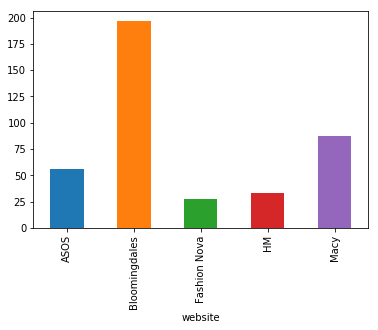

In [41]:
df.groupby(['website'])['price'].mean().plot.bar()

# data pre-processing

simple_preprocess() in word2vec will convert a document into a list of lowercase tokens, punctuation and numbers will be removed. However, futher pre-processing is needed before NLP

1) replace t-shirt/T-shirt with tshirt/Tshirt to be counted as one token

2) materials: 
convert (Viscose 100%) to (Viscose100%, Viscose)
convert (100% Viscose) to (Viscose100%, Viscose)

3) remove brands: 
PrettyLittleThing, ASOS DESIGN, 'ASOS', "YAS", "Ditsy", "Noisy", "May", "Ted","Baker", "River","Island", "Karen","Scott", "PrettyLittleThing", "Roxy", "DESIGN", "Chi", "Alfani", "Boohoo", "Sofie", "Schnoor", "Ellesse", "Jeannie", "TFNC", "Sacred", "Hawk", "Urban", "Bliss", "Puma", "adidas", "Stella"

4) remove words: 
cm
size,
‘Web ID:’ 
Approx. model height is 5'10" and she is wearing a size 4/S
Made In USA Made In USA


In [42]:
df = data_cleaning(df) # from data_cleaning

In [43]:
df.iloc[1128,0]

' a relaxed fit  cropped silhouette update th calvin klein performance tshirt  in soft fabric with a bold logo for a stylh addition to your active or casual look  hits at   relaxed fit inspired for  athleure round neckline  long sleeves with drop shoulders cotton modal spex mane washable impor       '

In [44]:
df.sample(5)


alltext        brand category  \
2605  layla silk animalprint blouse fits true to   o...  Elie Tahari      Top   
4441  wednesday s girl crop top with tie front in me...          NaN      Top   
4707  stradivarius vcose blouse with buttons the thi...          NaN      Top   
7003   square neck body not just any body square nec...          NaN      Top   
4691  monki fan print cropped blouse allover print i...          NaN      Top   

                                            description img_2  \
2605  Fits true to size, order your normal size,Mode...   NaN   
4441  Floral print,Cute, right?,Bardot neck,Tie fron...   NaN   
4707  The thing you didn't know you needed,V-neck,Bu...   NaN   
7003  Not just any body,Square neck,Press-stud faste...   NaN   
4691  All-over print,It's the little things that cou...   NaN   

                  img_id                                            img_url  \
2605  img9942369_fpx_tif  https://images.bloomingdalesassets.com/is/imag...   
4441                 NaN  https://images.asos-media.com/products/wednesd...   
4707                 NaN  https://images.asos-media.com/products/stradiv...   
7003                 NaN  https://images.asos-media.com/products/prettyl...   
4691                 NaN  https://images.asos-media.com/products/monki-f...   

                                               material  price  \
2605                                                NaN  348.0   
4441  Fine mesh ,For a subtle flash of skin,Body: 10...   24.0   
4707  Soft, woven fabric,Drapes like a dream,Main: 1...   32.0   
7003  Soft-touch jersey,Why complicate things?,Main:...   16.0   
4691  Stretch woven fabric,It's got a little give,Ma...   32.0   

                                           product_name        website    id  
2605                     Layla Silk Animal-Print Blouse  Bloomingdales  2605  
4441  Wednesday's Girl crop top with tie front in me...           ASOS  4441  
4707           Stradivarius viscose blouse with buttons           ASOS  4707  
7003                 PrettyLittleThing square neck body           ASOS  7003  
4691                     Monki Fan Print Cropped Blouse           ASOS  4691

note: no need to hold out the test data, as data is unlabelled (NLP is unsupervised learning)

# NLP Analysis

### word2vec

In [87]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

class MySentences(object): 
    def __iter__(self):
        for i in range(df.shape[0]):
            yield simple_preprocess(df.iloc[i,0]) # generator  


In [88]:
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

In [89]:
%%time
import multiprocessing
import os
cores = multiprocessing.cpu_count()

if not os.path.exists('models/word2vec.model'):
    print("start traing word2vec model...")
    sentences = MySentences() # a memory-friendly iterator
    #10 hidden layers, look up -5/+5 window. Drop out words show up less than 2 times
    word2vec_model = gensim.models.Word2Vec(sentences, size=10, window=5, min_count=2, workers=cores)  
    
    #epoch larger to ensure it converge
    word2vec_model.train(sentences, total_examples = word2vec_model.corpus_count, epochs=10)
                
    if not os.path.exists('models'):                                                          
        os.makedirs('models')
        word2vec_model.save('models/word2vec.model')
    else:
        word2vec_model.save('models/word2vec.model')
else:
    word2vec_model = Word2Vec.load('models/word2vec.model')

CPU times: user 19.4 ms, sys: 1.94 ms, total: 21.3 ms
Wall time: 25.4 ms


## Method 1: pretrained model for word2vec

#### use pretrained model because our sample size is too small (only around 50k words) compare to pretrained models with 100k or 1M words

In [546]:
from pretrain_model import *
from IPython.display import Image

In [65]:
pretrain_model = loadGloveModel('glove.42B.300d.txt')

Loading Glove Model
Done. 1917494  words loaded!


In [96]:
print( find_similar(df, 100, pretrain_model, count = 20))
pretrain_similar = find_similar(df, 100, pretrain_model, count = 20)

[(100, 1.0), (204, 0.960734265828717), (127, 0.9532909762977771), (206, 0.9518106946985845), (129, 0.9515571908715034), (74, 0.9505915234467651), (253, 0.9501979595726253), (113, 0.9492253970828751), (257, 0.9492253970828751), (231, 0.9476012341353779), (34, 0.9456792049094209), (67, 0.9422398250427261), (221, 0.9420453052039244), (188, 0.9405505509835118), (538, 0.9393099703403387), (170, 0.9385514286183384), (35, 0.9385514286183383), (9771, 0.937779079079627), (161, 0.9373998739795714), (200, 0.9372290849067381)]


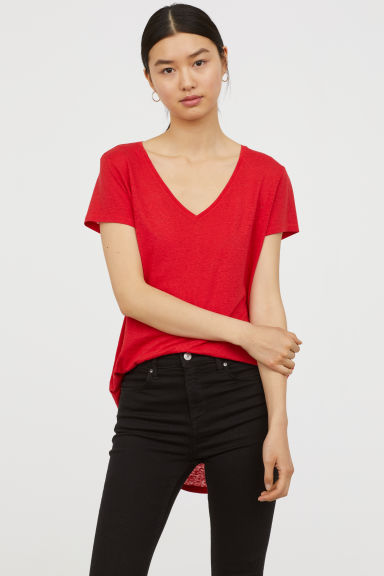

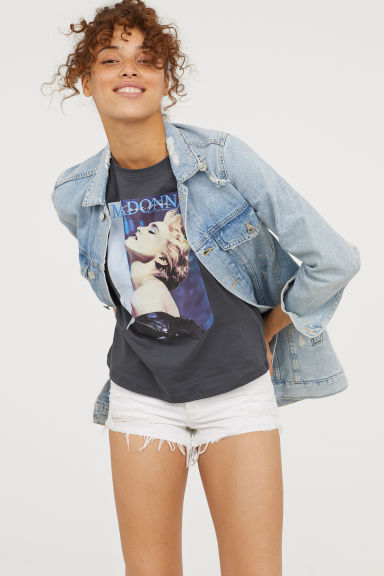

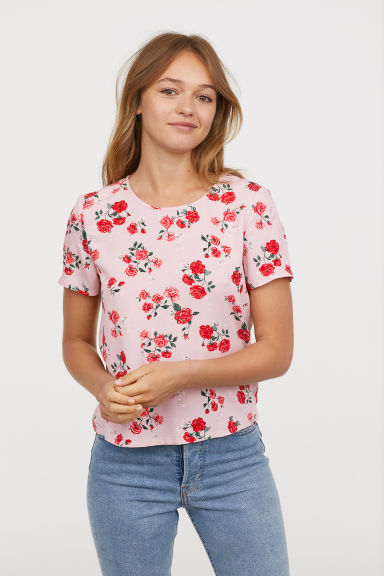

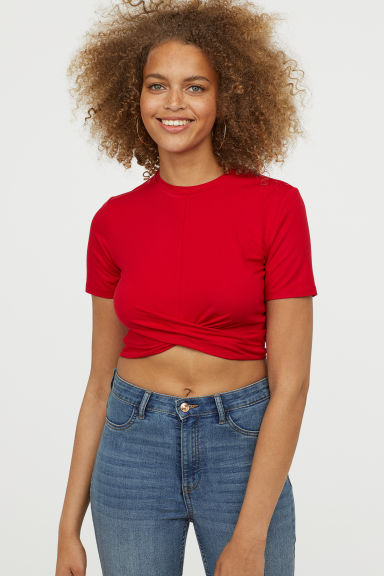

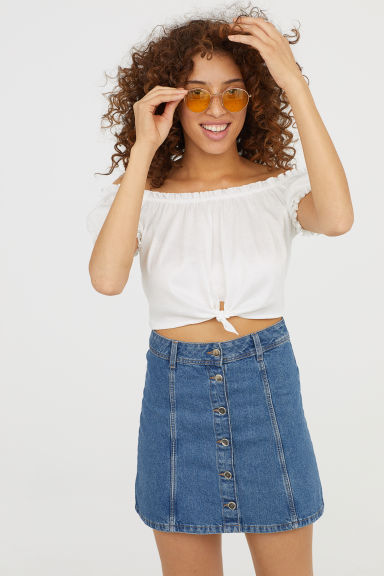

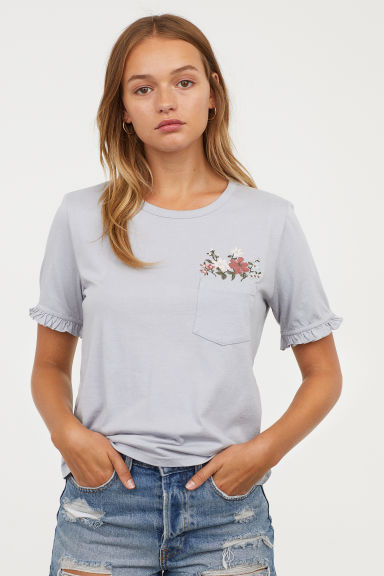

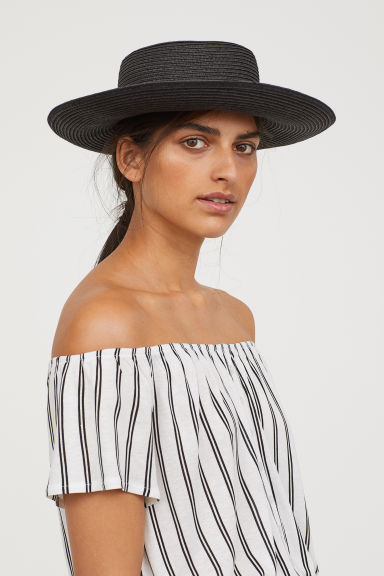

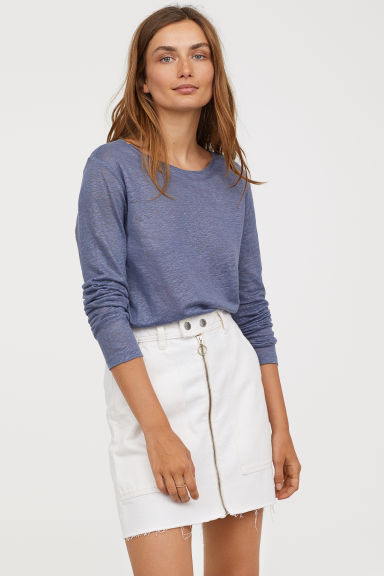

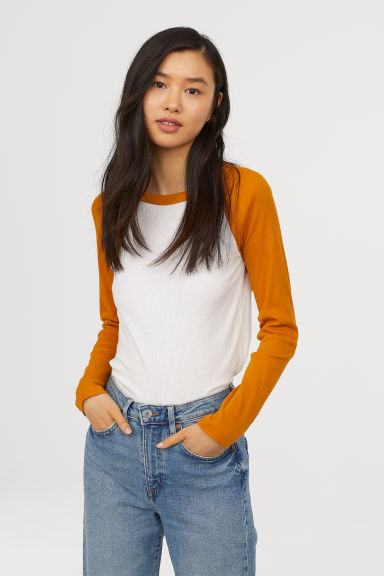

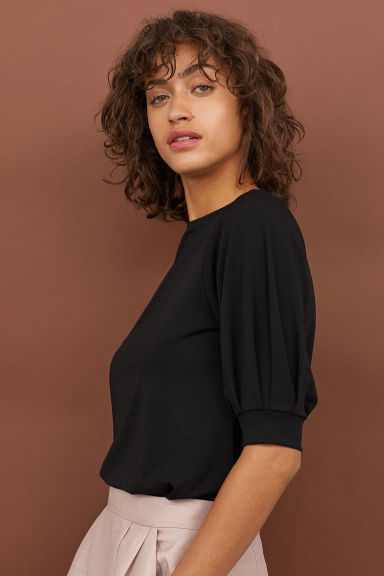

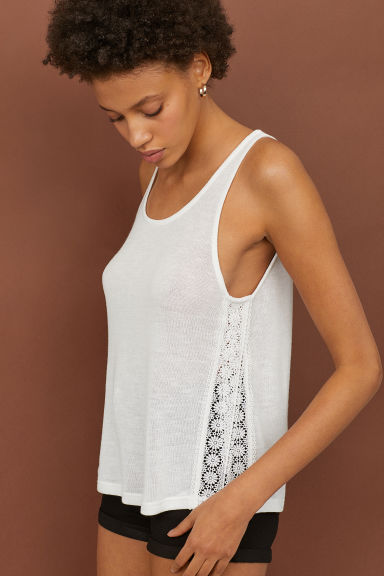

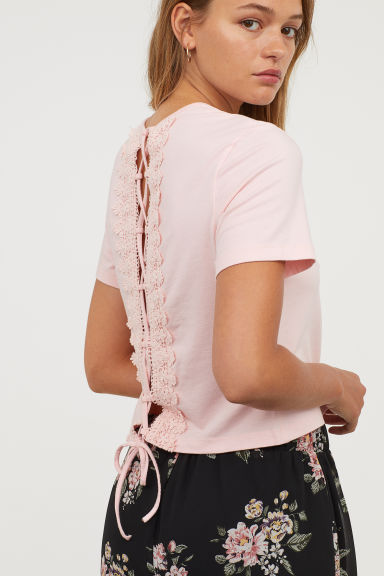

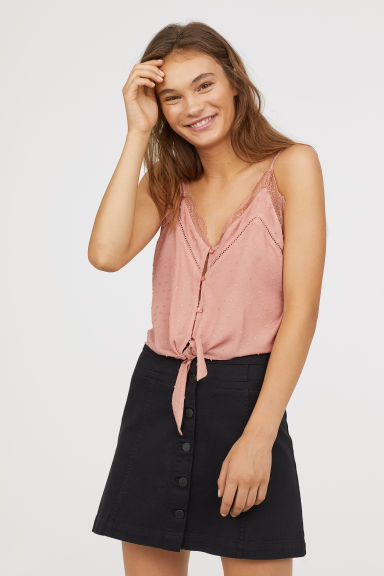

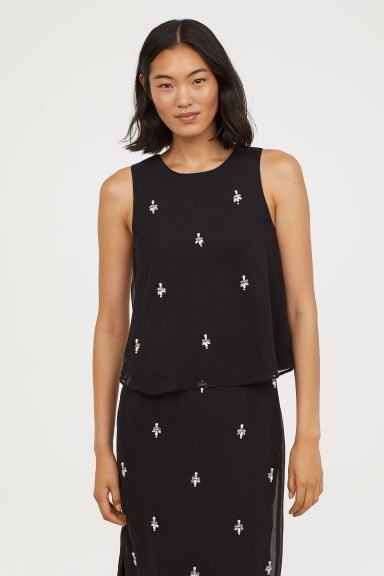

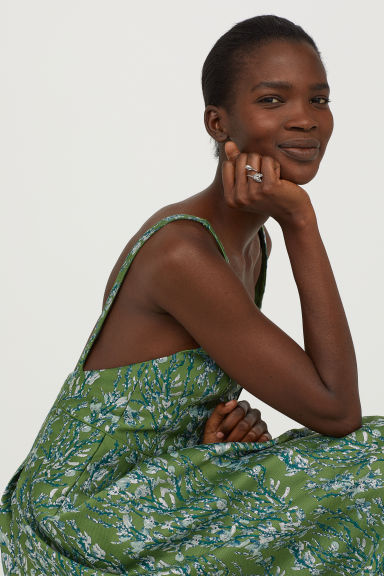

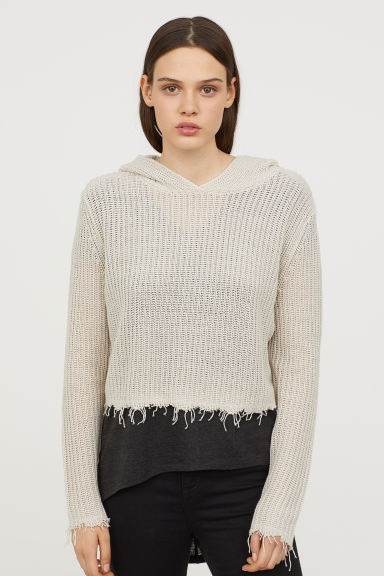

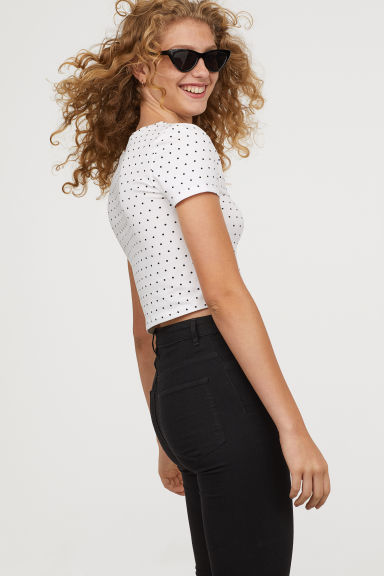

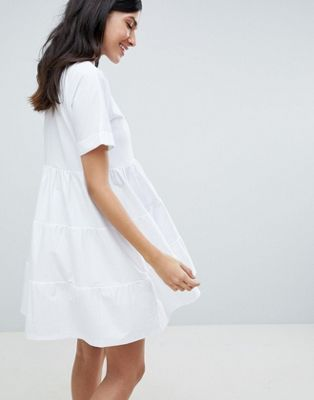

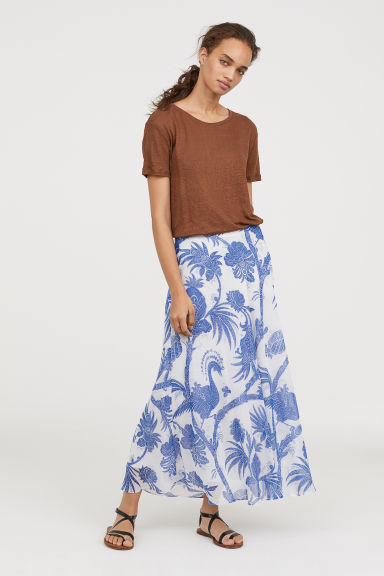

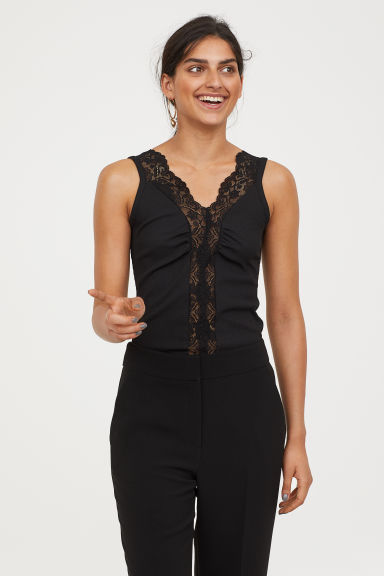

In [98]:
for i in range(len(pretrain_similar)):
    display(Image(filename = './product_images/'+str(pretrain_similar[i][0])+'.jpg', width=200, height=200))

## Method 2: tfidf 

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [354]:
tfidf_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=simple_preprocess,   # tokenizer = nltk.word_tokenize
    preprocessor=None, stop_words='english', max_features=None)     


features = tfidf.fit_transform(df.alltext)
tfidf_list = list(map(list, (zip(tfidf.get_feature_names(), tfidf.idf_))))

In [355]:
for i in range(len(tfidf_list)): 
    tfidf_list[i][1] =  1/ tfidf_list[i][1]  # make more common words have larger weight

In [356]:
tfidf_list = sorted(tfidf_list, key =lambda x: x[1], reverse = True)  # sorted from most common to least common words
tfidf_list  

[['fit', 0.6641807474084849],
 ['polyester', 0.627710040728446],
 ['the', 0.6269271824614803],
 ['neck', 0.6175632108913555],
 ['in', 0.5941717765136499],
 ['with', 0.5738299890473423],
 ['to', 0.5661050010399117],
 ['regular', 0.5584731971379382],
 ['you', 0.5500416573788085],
 ['dress', 0.5369939838411777],
 ['fabric', 0.5283431939412329],
 ['main', 0.5277307698647722],
 ['for', 0.5054497712853078],
 ['cut', 0.490250236368261],
 ['cotton', 0.4750316129564341],
 ['spex', 0.46931317971364406],
 ['sleeves', 0.4650184680652905],
 ['fits', 0.45627335749436654],
 ['body', 0.4532601704998643],
 ['just', 0.44694610125150186],
 ['that', 0.43777967735083667],
 ['right', 0.4357048628293543],
 ['it', 0.4305742241655432],
 ['back', 0.4288365305910112],
 ['jersey', 0.41807748588659804],
 ['front', 0.40933562780575544],
 ['woven', 0.40415098456987886],
 ['top', 0.40329575370034837],
 ['true', 0.3969965866495376],
 ['your', 0.3921658541949286],
 ['of', 0.38839405475612365],
 ['th', 0.381815093174300

In [159]:
tfidf_dict = dict(tfidf_list)

In [595]:
from tfidf import *
# find_similar(df, 100, tfidf_dict, count = 10)

## Method 3: doc2vec

In [21]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [69]:
# MyDocs reading from a data frame
class MyDocs(object):
    def __iter__(self):
        for i in range(df.shape[0]):
            yield TaggedDocument(words=simple_preprocess(df.iloc[i,0]), tags=['%s' % df.iloc[i,-1]])  
            # TaggedDocument classify reviews

In [105]:
%%time

if not os.path.exists('models/doc2vec.model'):
    print("start traing doc2vec model...")
    documents = MyDocs()                                                          
    doc2vec_model = Doc2Vec(dm=0, dbow_words=1, vector_size=200, window=3, min_count=2, workers=cores)
    doc2vec_model.build_vocab(documents)
    doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=100) 
    if not os.path.exists('models'):
        os.makedirs('models')
        doc2vec_model.save('models/doc2vec.model')
    else:
        doc2vec_model.save('models/doc2vec.model')
else:
    doc2vec_model = Doc2Vec.load('models/doc2vec.model')
    
    # no pretrained model for doc to vec because each document is unique per training set. word to vec can be generalized

start traing doc2vec model...
CPU times: user 7min 26s, sys: 22.2 s, total: 7min 48s
Wall time: 4min 7s


In [242]:
def load_img_d2v(model, item, n):
    doc2vec_model = Doc2Vec.load(model)
    print(doc2vec_model.docvecs.most_similar(item, topn=n))
    d2v_similar = doc2vec_model.docvecs.most_similar(item, topn=n)

    # show img
    display(Image(filename = './product_images/'+item+'.jpg', width=200, height=200))
    for i in range(len(d2v_similar)):
        display(Image(filename = './product_images/'+str(d2v_similar[i][0])+'.jpg', width=200, height=200))

[('1', 0.6814905405044556), ('330', 0.6718116998672485), ('336', 0.664460301399231), ('20', 0.6572907567024231), ('4669', 0.6533445119857788), ('31', 0.6359493732452393), ('6511', 0.6346524357795715), ('572', 0.621757447719574), ('41', 0.6154969334602356), ('7346', 0.6151467561721802), ('5059', 0.6096570491790771), ('190', 0.6023114919662476), ('5290', 0.6019721627235413), ('8212', 0.597015380859375), ('5380', 0.5959575176239014), ('37', 0.5954045057296753), ('3589', 0.5934072732925415), ('9857', 0.5932191610336304), ('545', 0.5928370952606201), ('6333', 0.5899505019187927)]


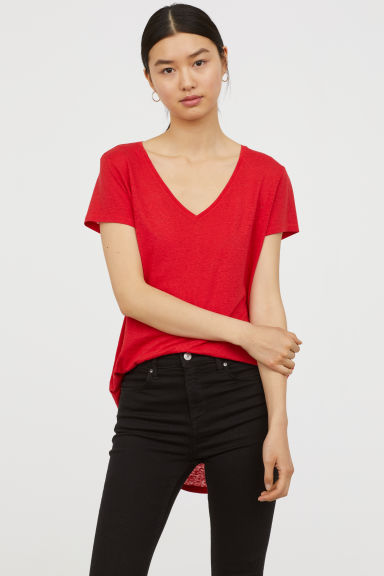

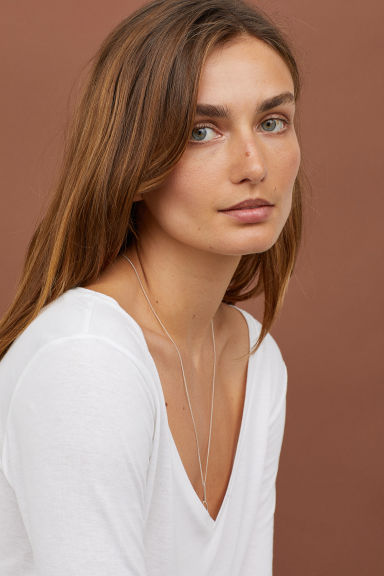

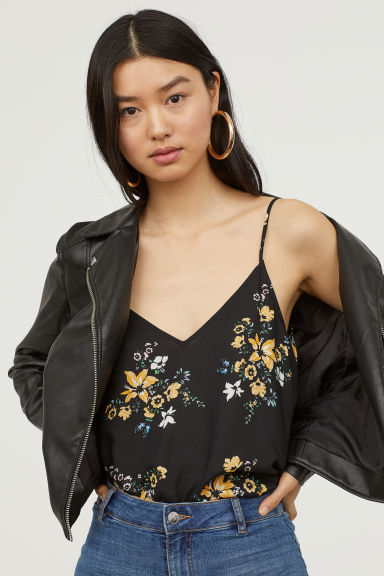

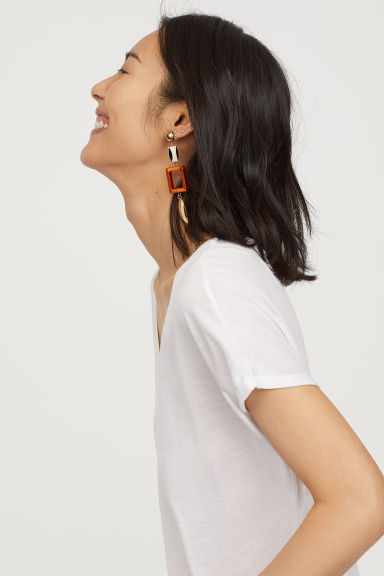

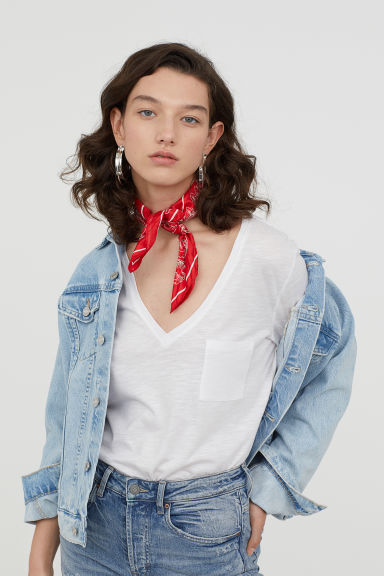

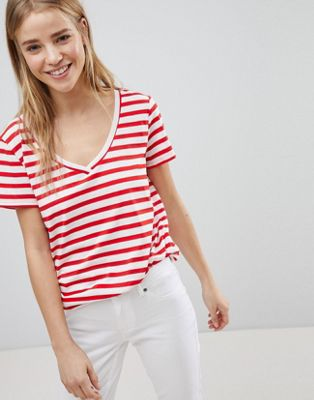

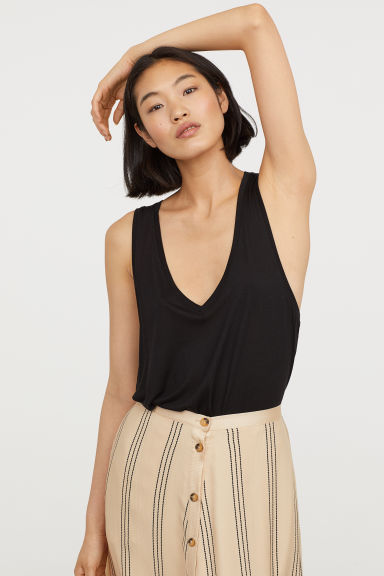

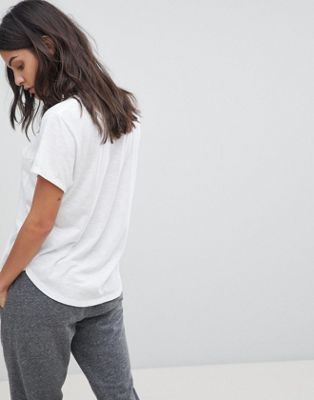

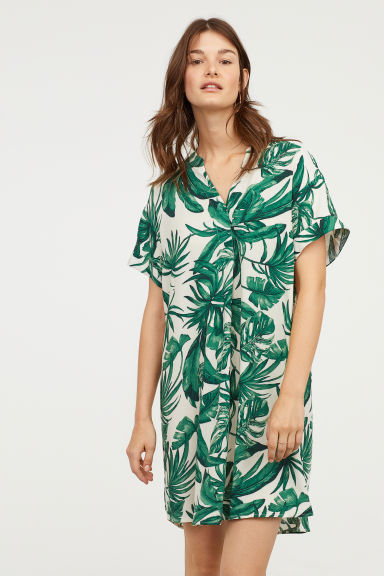

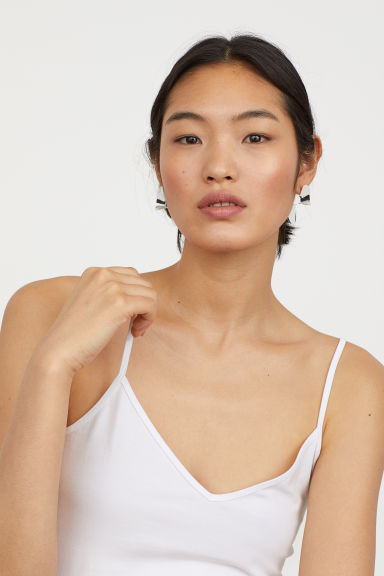

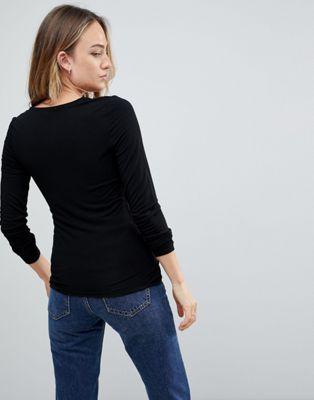

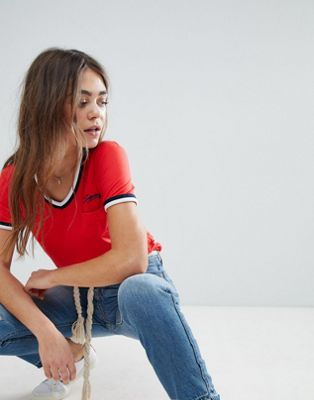

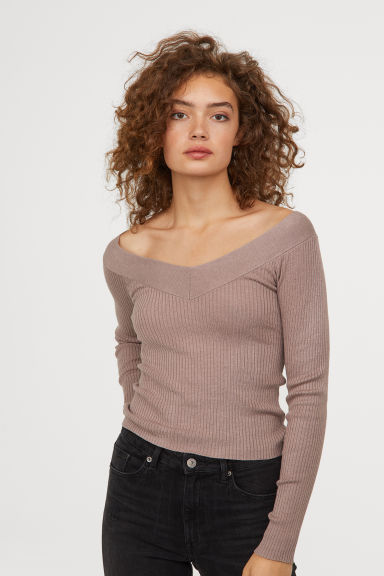

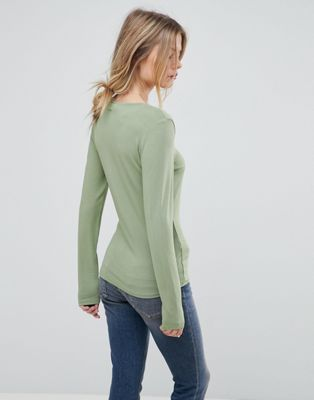

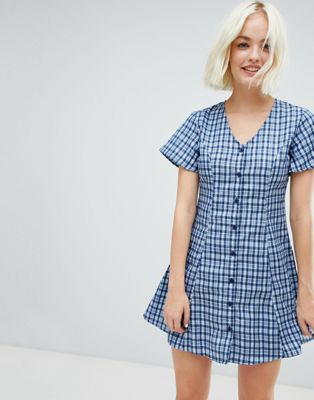

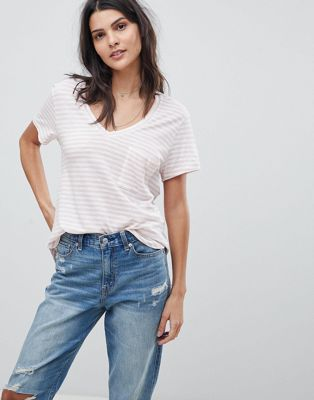

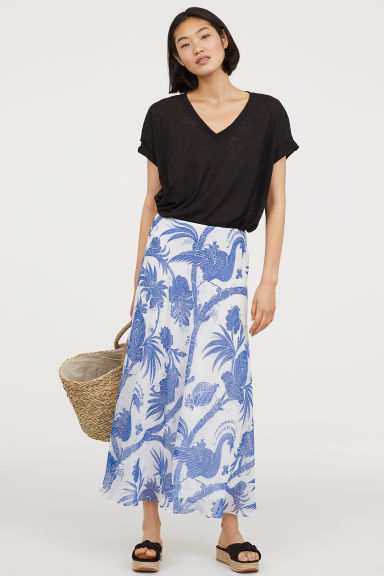

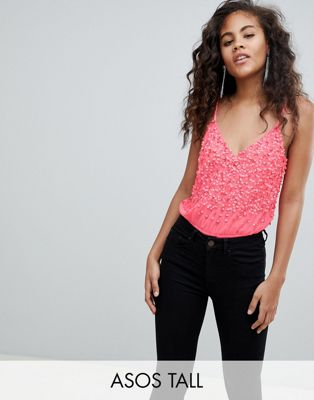

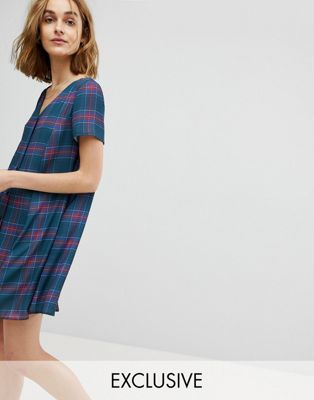

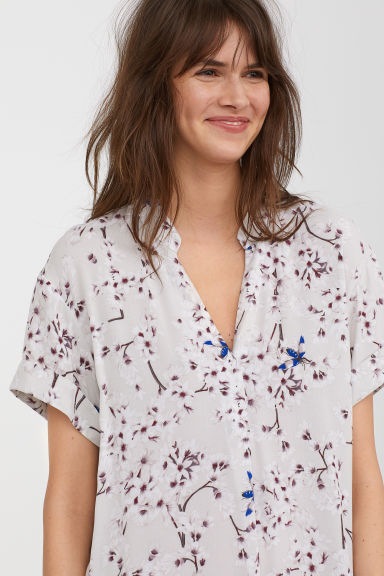

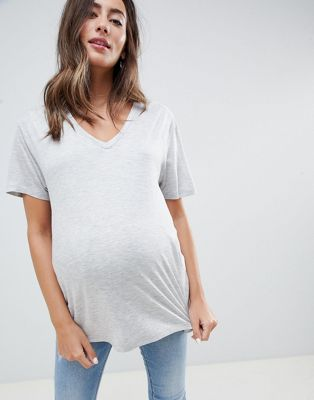

In [113]:
# dm = 1, dbow_words=1

load_img_d2v('models/doc2vec_dm1_word1_vec200_win3_min2_epoch100.model', '100', 20)    

[('336', 0.7351894378662109), ('20', 0.7306736707687378), ('1', 0.7166502475738525), ('31', 0.6706709861755371), ('572', 0.6669712066650391), ('41', 0.6623464822769165), ('4669', 0.652741551399231), ('37', 0.6434482932090759), ('330', 0.6420900821685791), ('5380', 0.6354026794433594), ('8212', 0.6344871520996094), ('220', 0.6320120096206665), ('7346', 0.6317950487136841), ('5290', 0.6313682794570923), ('9857', 0.6305119395256042), ('6511', 0.626423180103302), ('9357', 0.6145697236061096), ('3589', 0.6110650897026062), ('908', 0.6074733734130859), ('51', 0.6051846742630005)]


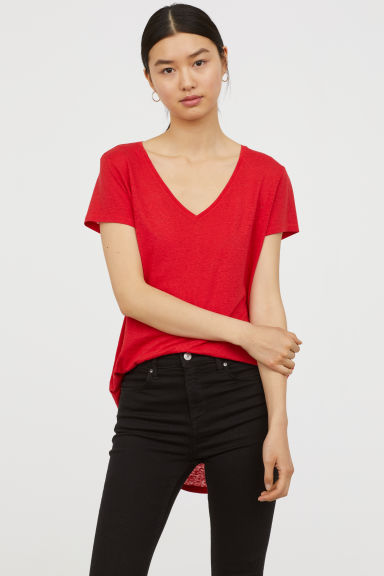

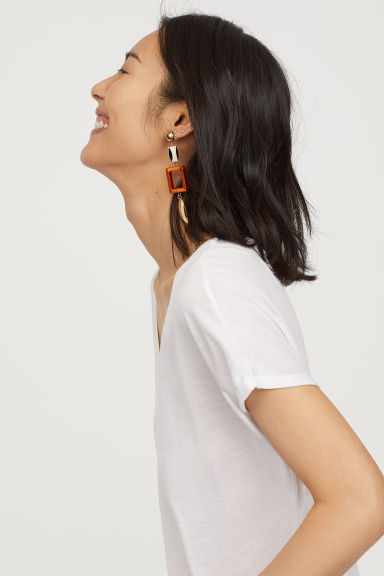

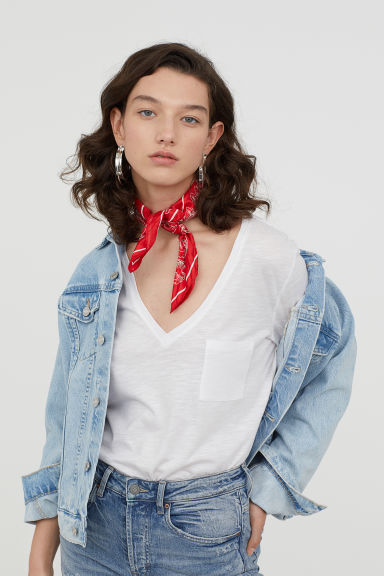

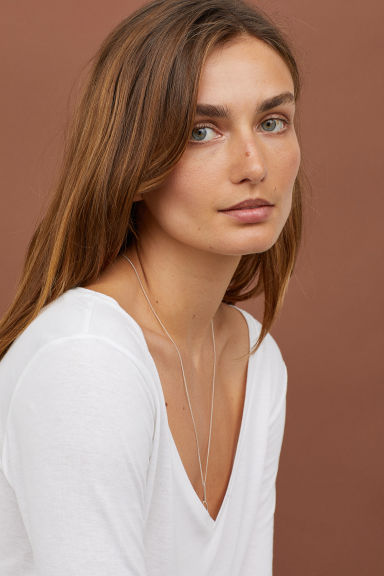

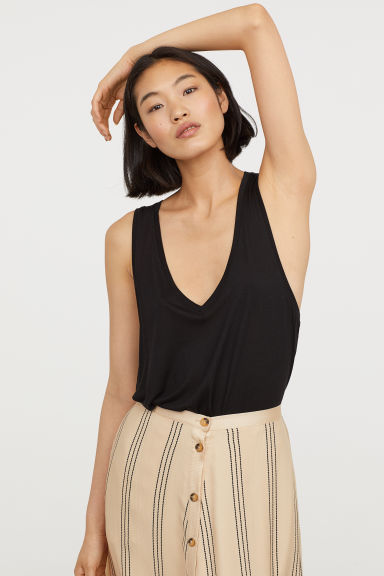

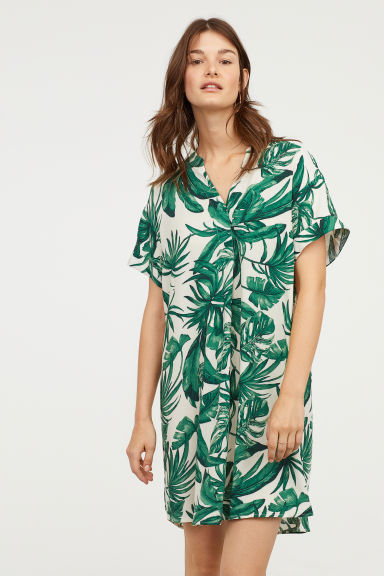

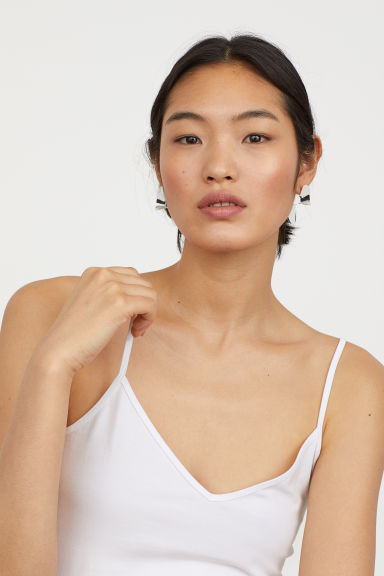

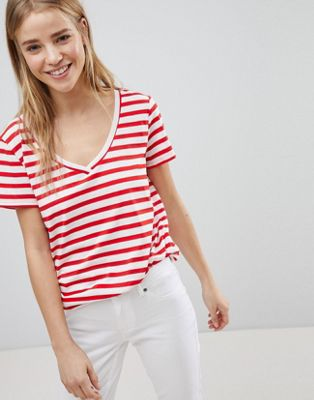

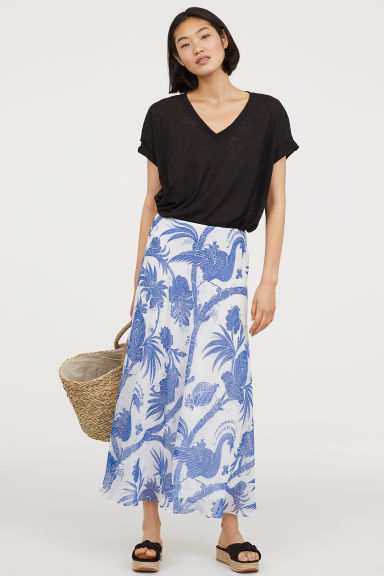

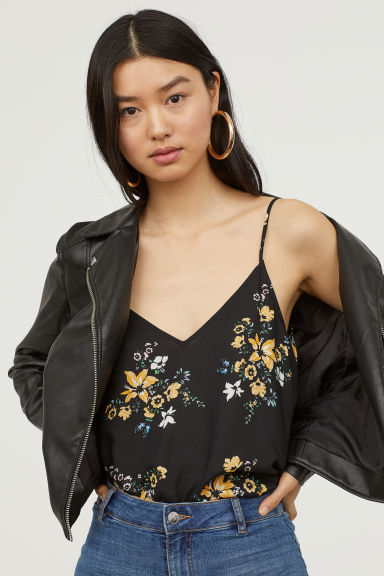

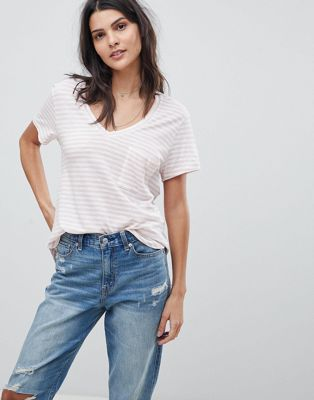

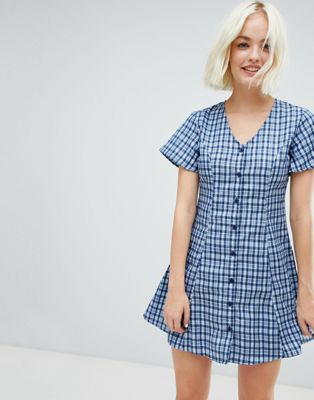

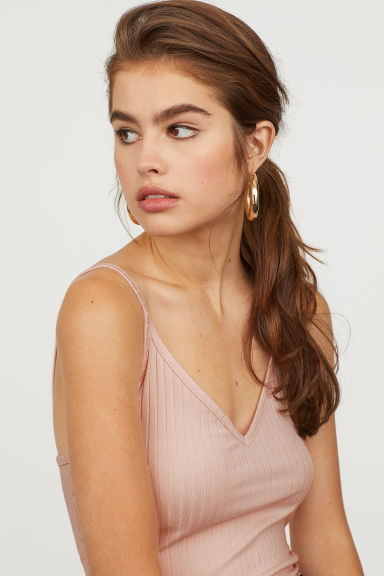

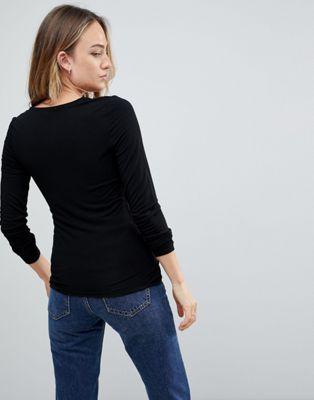

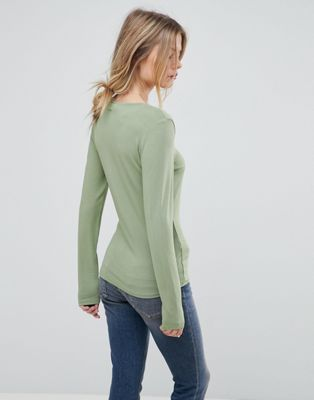

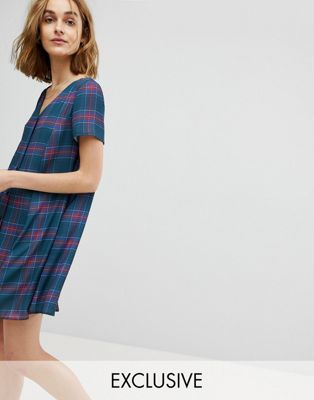

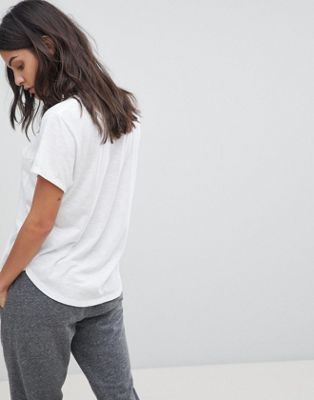

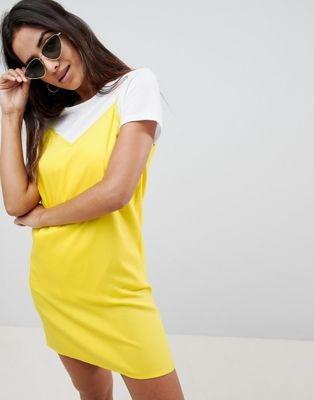

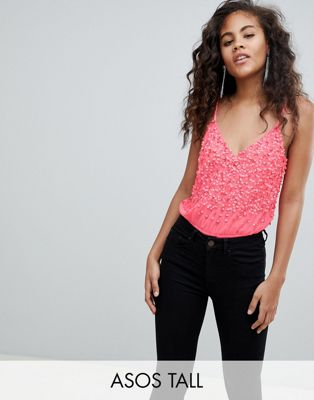

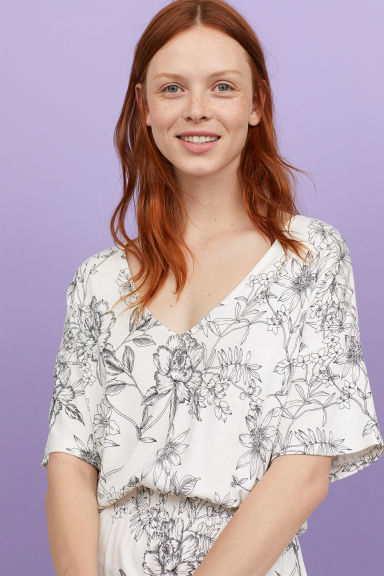

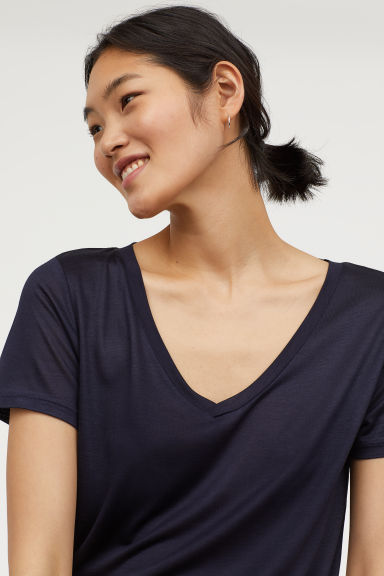

In [115]:
# dm = 1, dbow_words=0

load_img_d2v('models/doc2vec_dm1_word0_vec200_win3_min2_epoch100.model', '100', 20)    

[('104', 0.8012616038322449), ('246', 0.7907514572143555), ('31', 0.7750335931777954), ('165', 0.7597472667694092), ('363', 0.7514280080795288), ('125', 0.7504191398620605), ('309', 0.7445961236953735), ('20', 0.7143840789794922), ('32', 0.7107826471328735), ('317', 0.702681303024292), ('448', 0.7026429176330566), ('316', 0.7001550197601318), ('344', 0.6965476274490356), ('351', 0.6946157813072205), ('293', 0.6943001747131348), ('123', 0.6910964250564575), ('186', 0.6806600689888), ('542', 0.6777329444885254), ('109', 0.6772640943527222), ('70', 0.6770895719528198)]


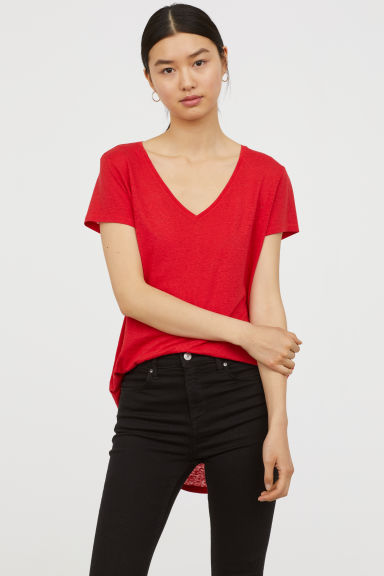

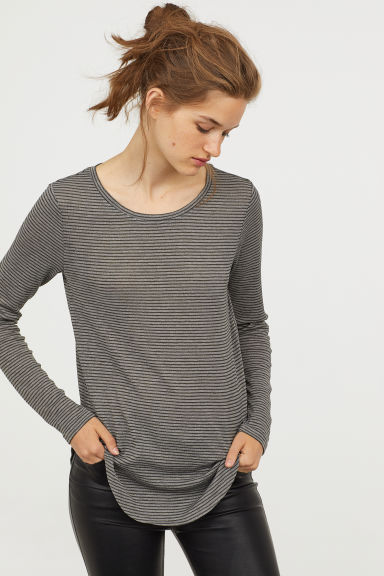

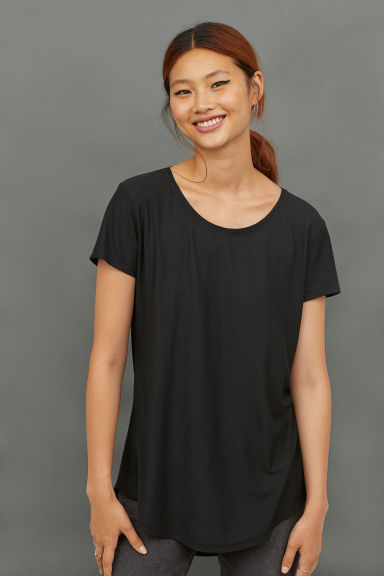

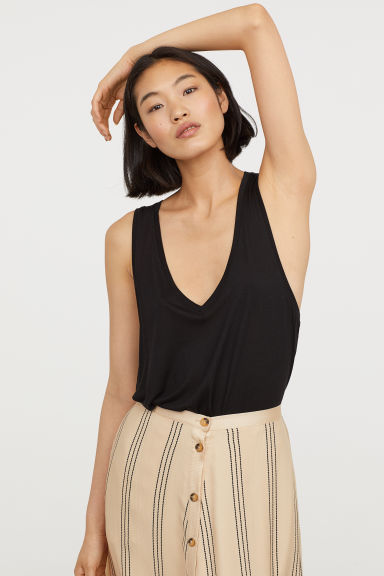

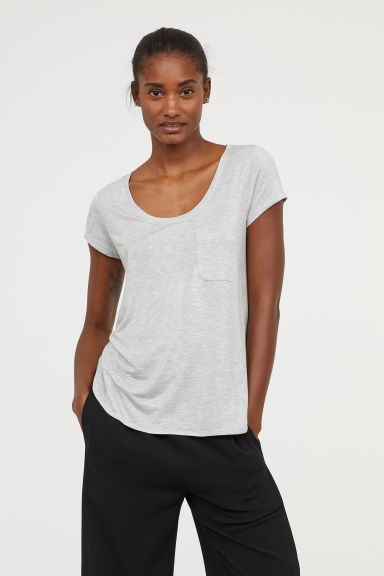

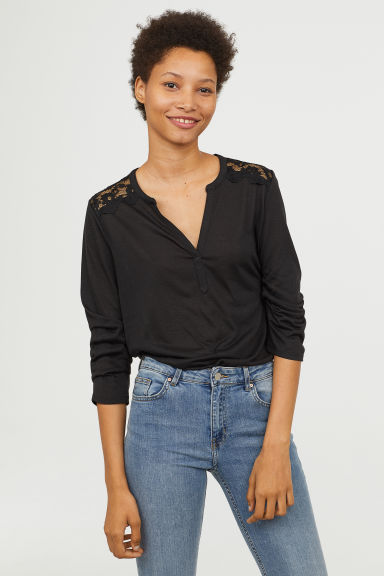

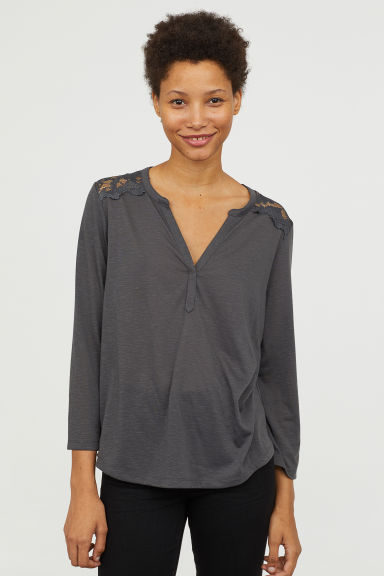

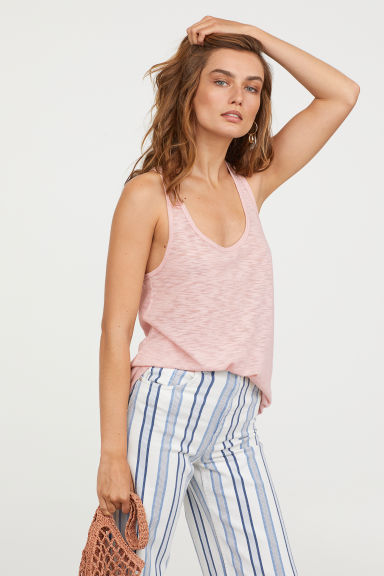

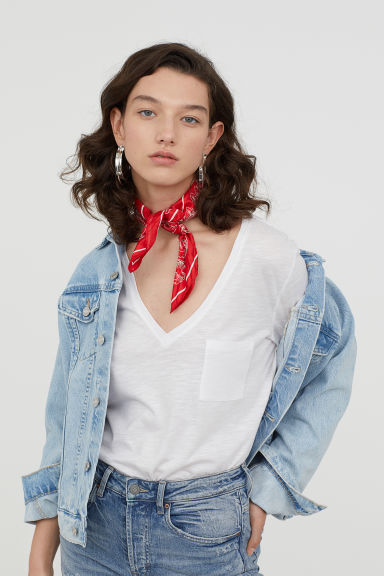

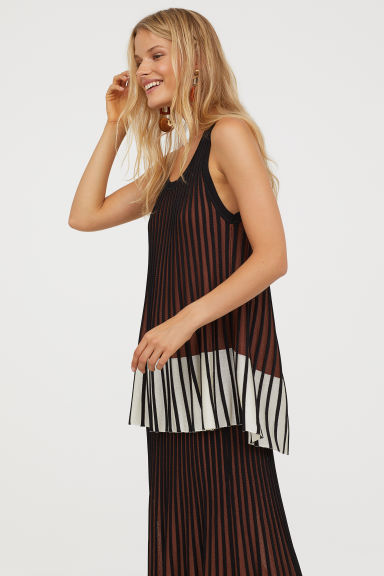

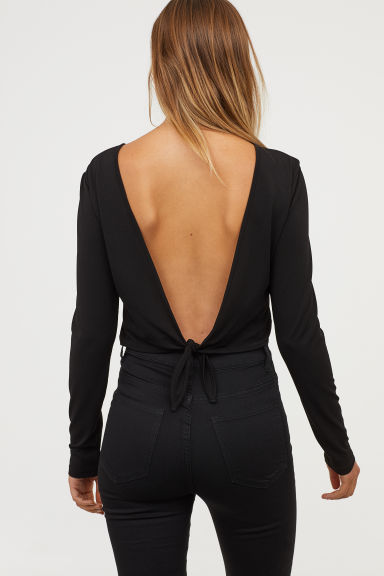

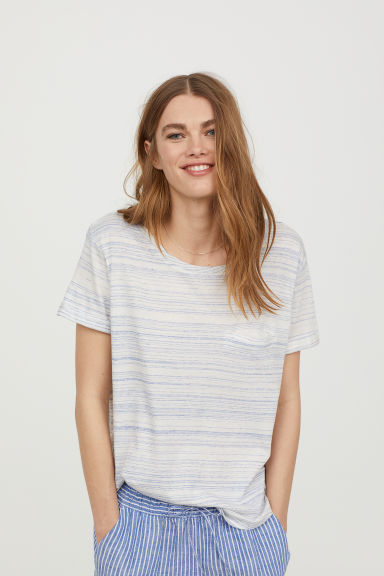

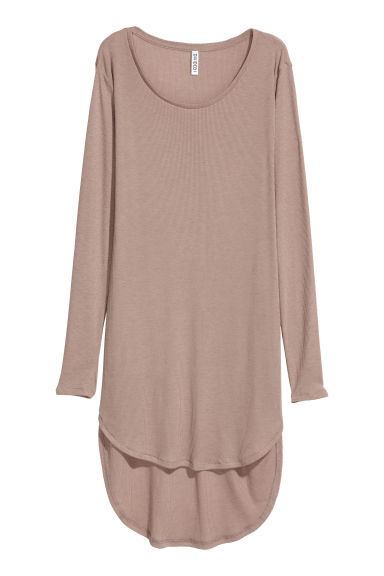

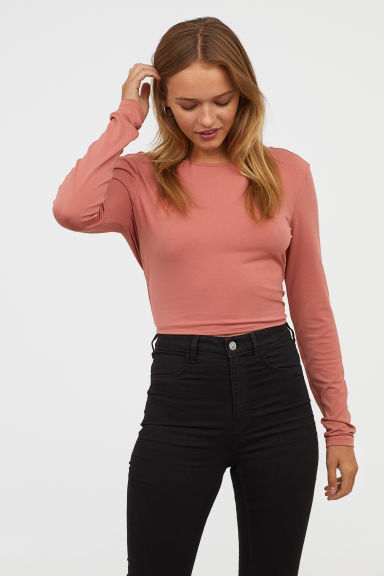

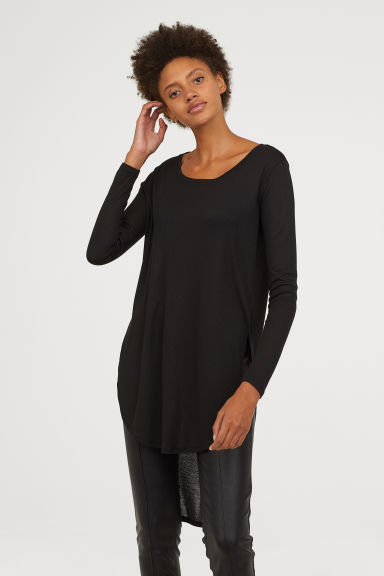

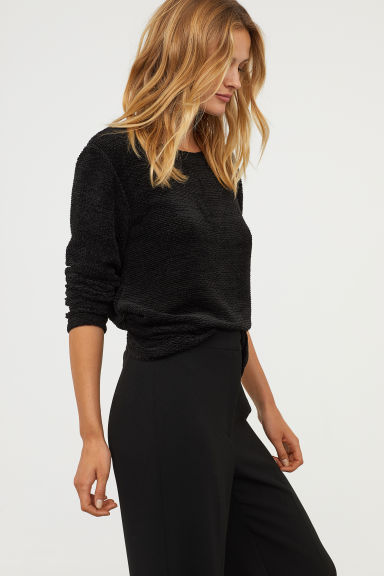

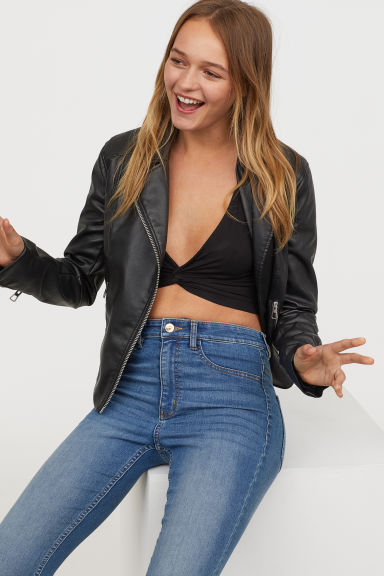

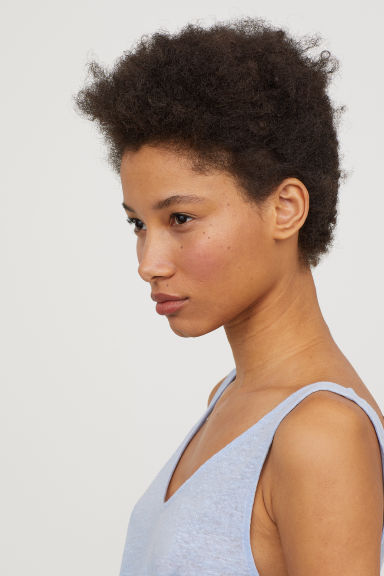

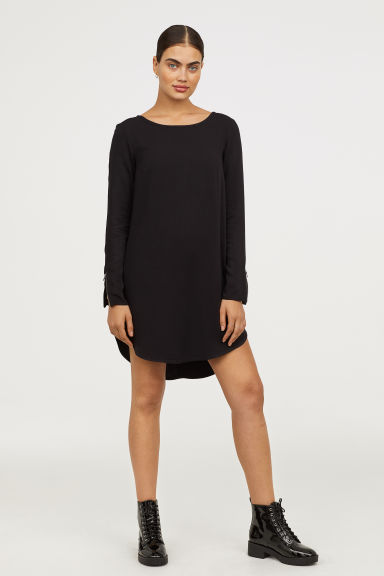

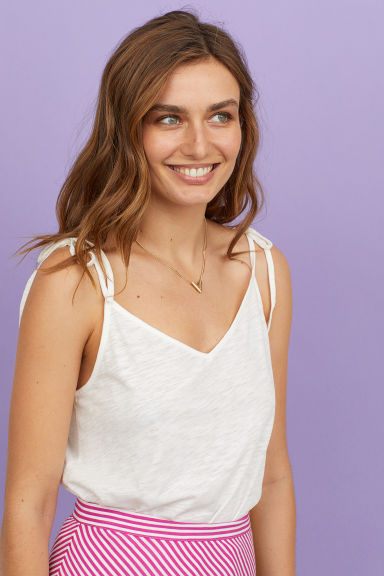

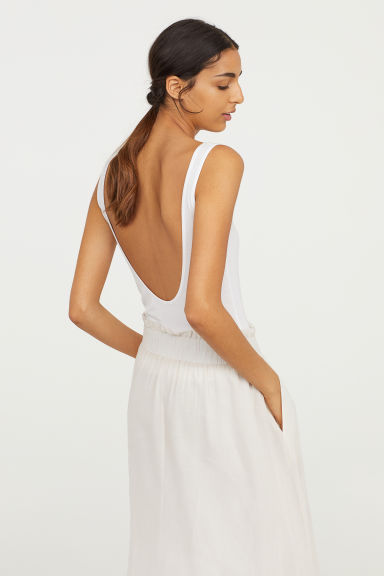

In [116]:
# dm = 0, dbow_words=1
load_img_d2v('models/doc2vec_dm0_word1_vec200_win3_min2_epoch100.model', '100', 20)    

[('2461', 0.9580557346343994), ('2551', 0.8022936582565308), ('2343', 0.796817421913147), ('2420', 0.737307608127594), ('2329', 0.7368664741516113), ('2230', 0.7350598573684692), ('2409', 0.7295939922332764), ('2325', 0.7275587320327759), ('2419', 0.719388484954834), ('2278', 0.7172719240188599), ('2507', 0.7123444080352783), ('2537', 0.7095582485198975), ('2214', 0.7083978652954102), ('2557', 0.7070801258087158), ('2535', 0.7066393494606018), ('2208', 0.695854663848877), ('2319', 0.6934138536453247), ('2179', 0.6922688484191895), ('2373', 0.6869860887527466), ('2378', 0.6837517619132996), ('2402', 0.6777701377868652), ('2279', 0.6720247268676758), ('2523', 0.6672313213348389), ('2282', 0.6633118391036987), ('2400', 0.661859929561615), ('2592', 0.6589052677154541), ('2217', 0.6563152074813843), ('2418', 0.6474432349205017), ('2331', 0.6391724348068237), ('2478', 0.6385031342506409), ('2463', 0.6345561742782593), ('2406', 0.6322240233421326), ('2469', 0.6277157664299011), ('2249', 0.627

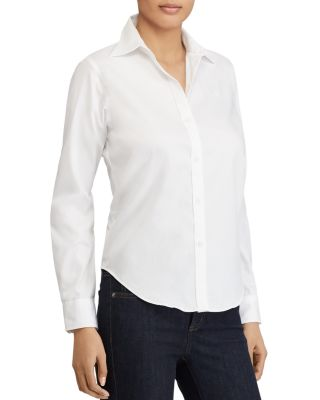

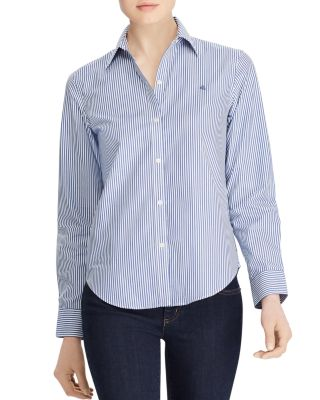

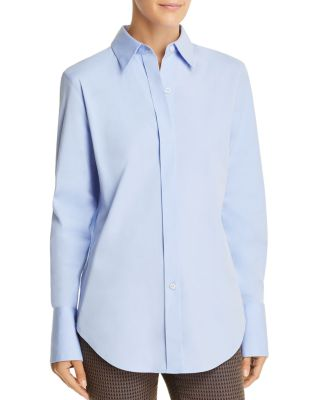

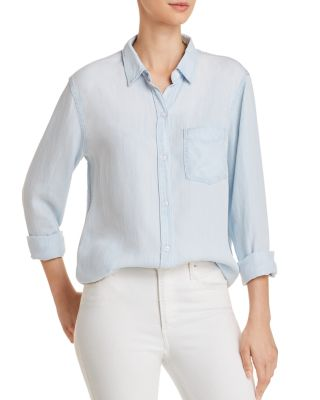

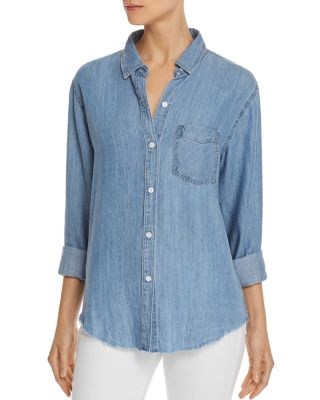

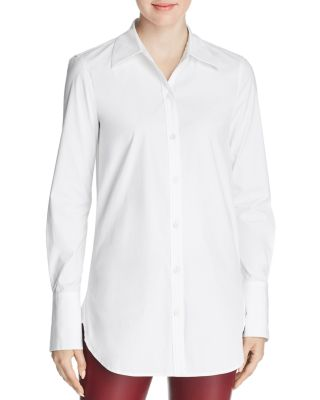

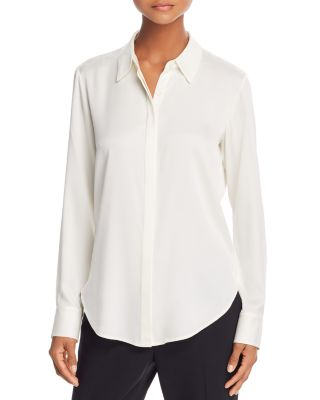

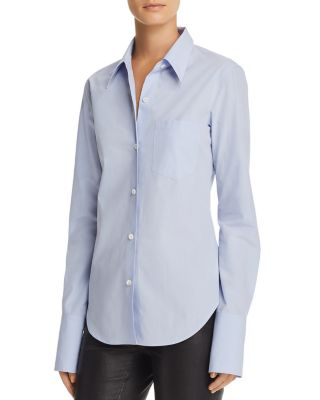

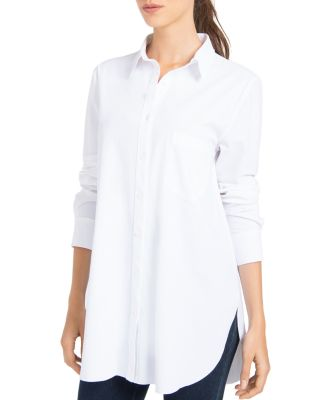

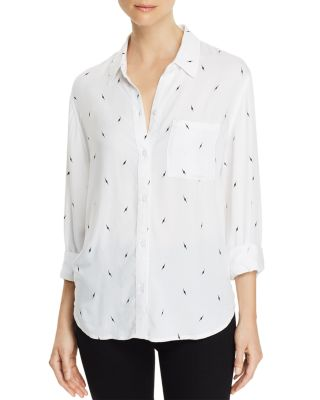

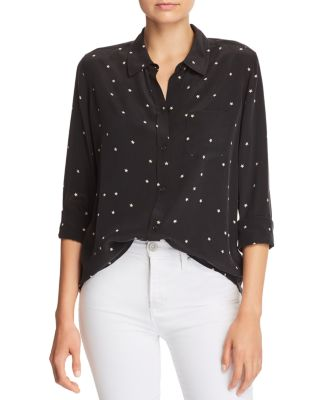

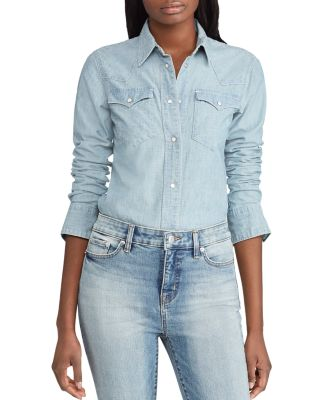

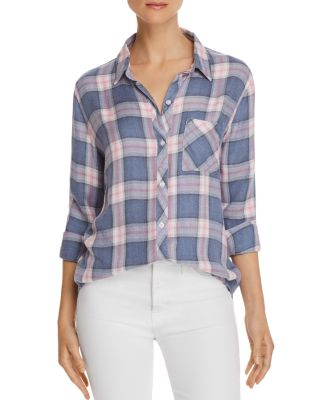

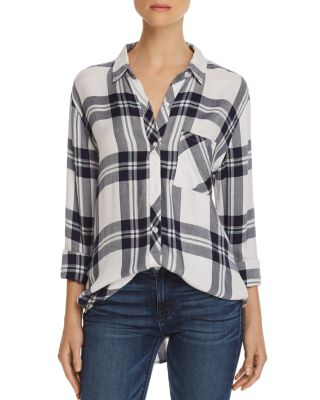

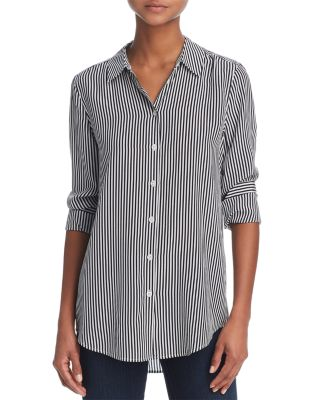

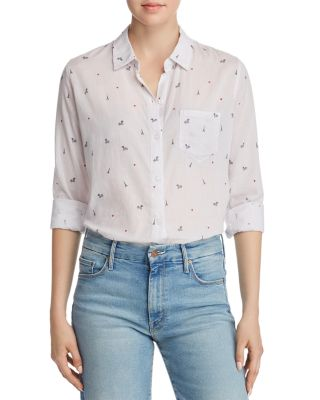

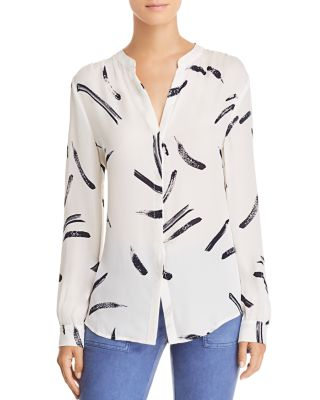

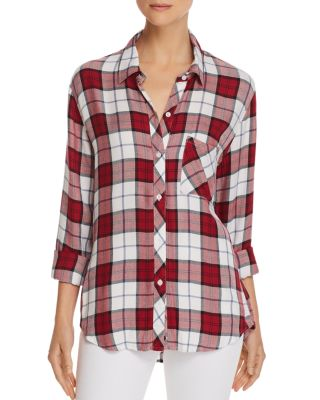

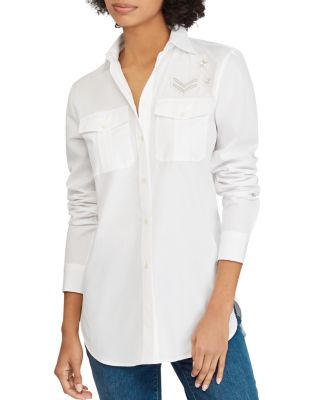

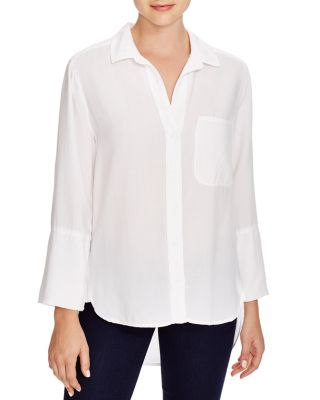

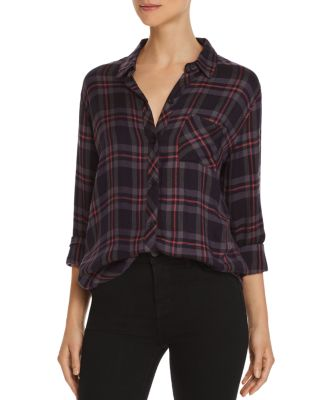

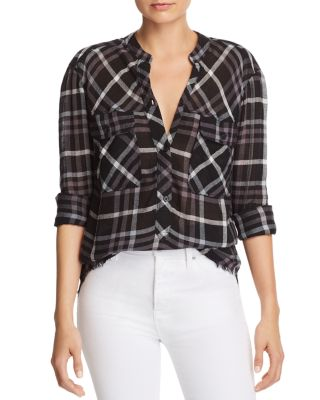

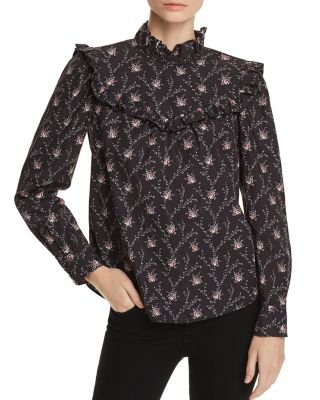

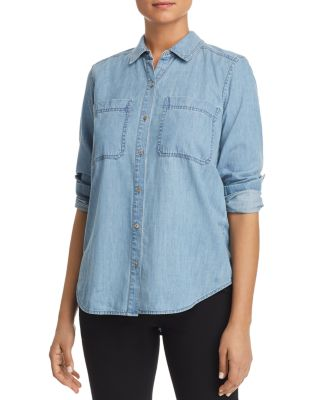

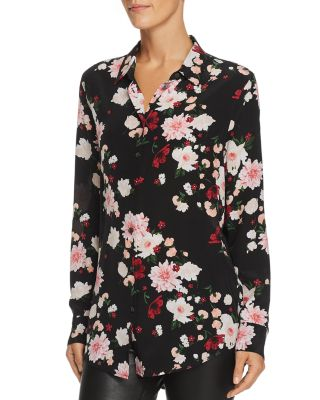

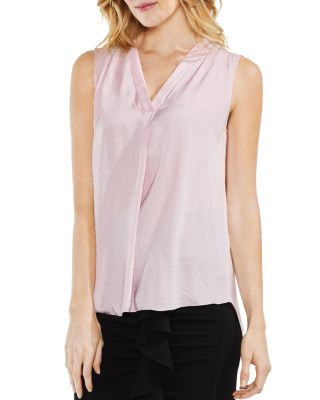

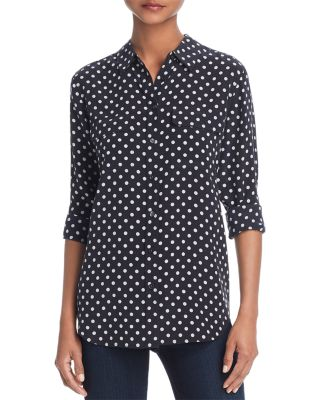

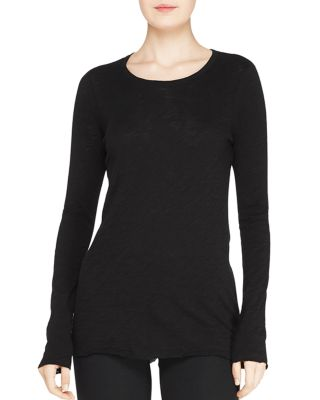

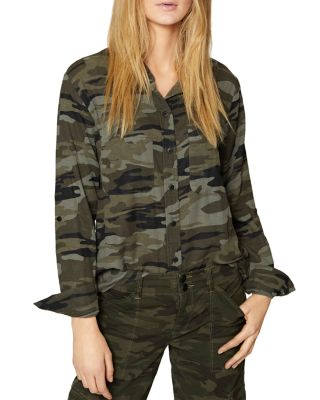

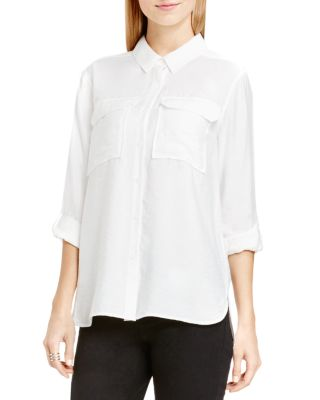

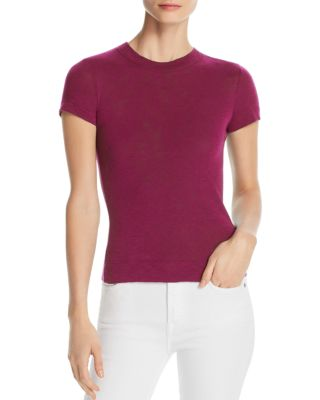

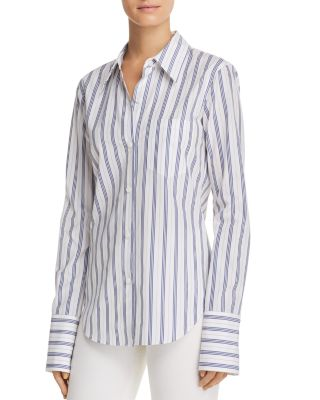

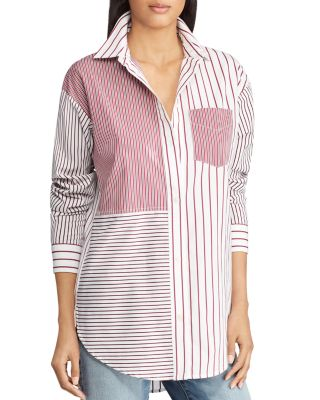

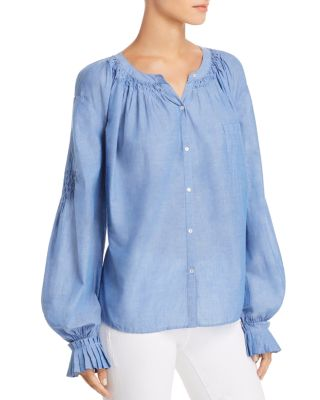

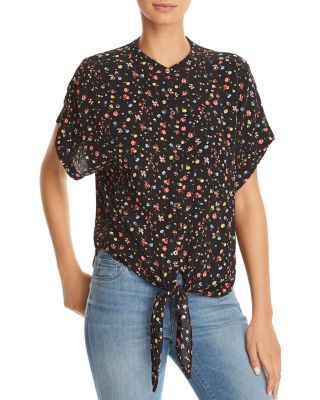

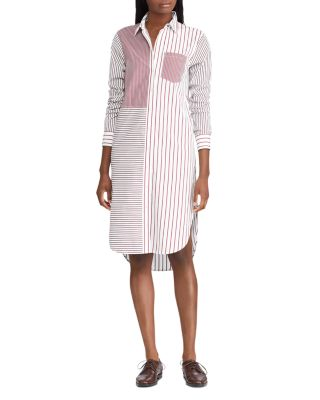

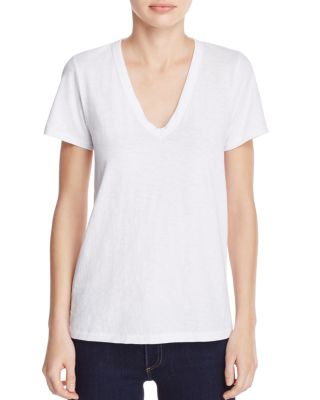

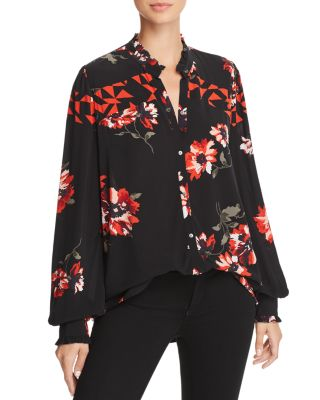

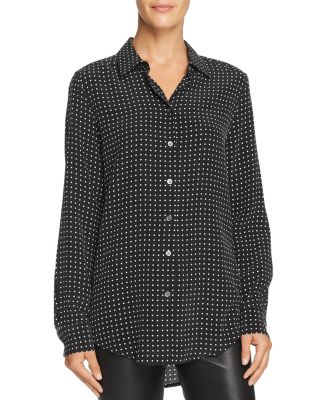

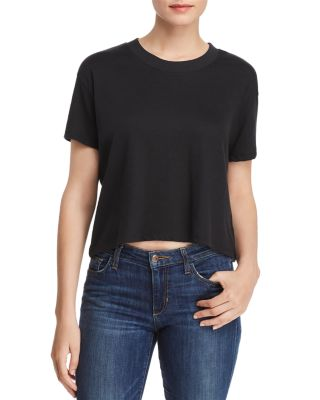

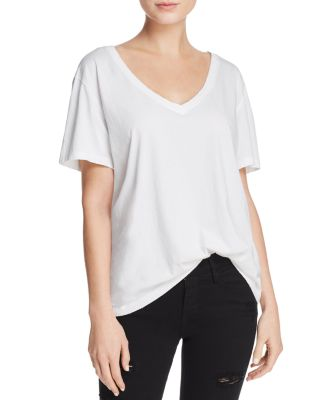

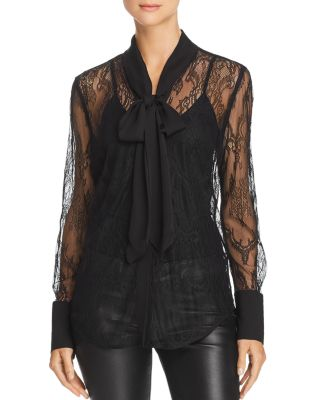

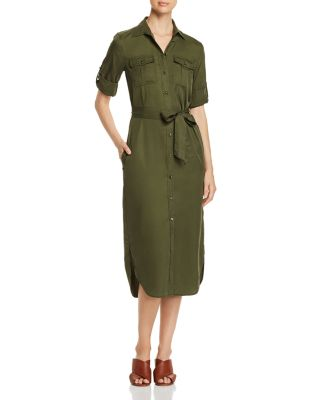

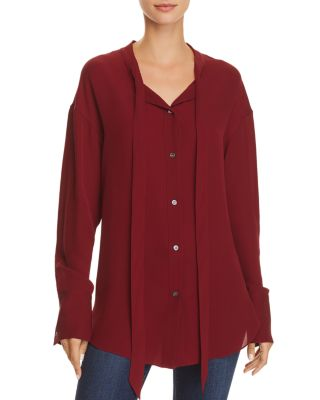

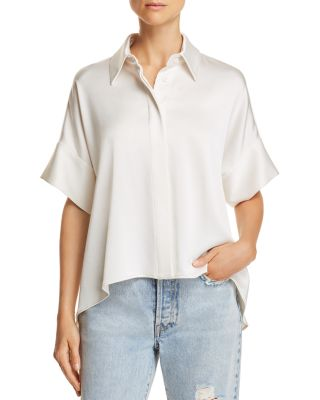

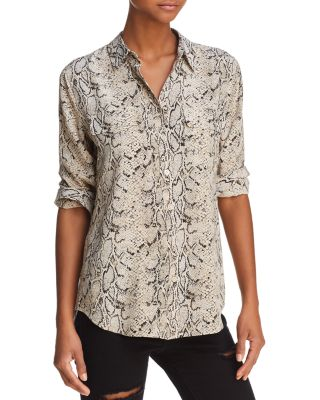

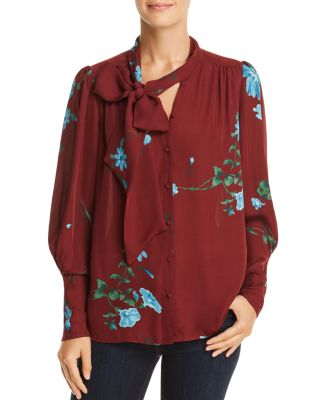

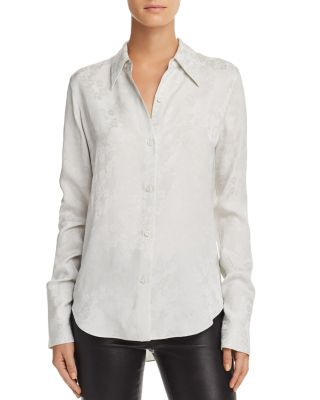

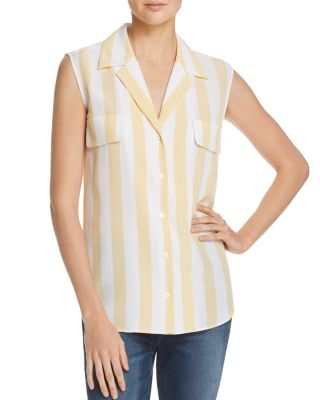

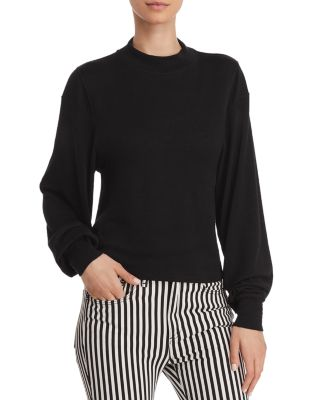

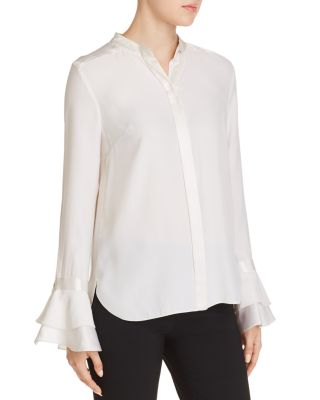

In [289]:
# dm = 0, dbow_words=0

load_img_d2v('models/doc2vec_dm0_word0_vec200_win3_min2_epoch100.model', '2300', 50)    

## product similarity based on image analysis

In [3]:
from IPython.display import Image
import pandas as pd

In [12]:
img_score = pd.read_csv('product_similarity_matrix.csv')
img_score = img_score.drop('Unnamed: 0', axis=1)
img_score.index = img_score.columns.values.tolist() # change row names to img name
img_score.to_pickle('product_similarity_matrix.pkl')

In [13]:
img_score = pd.read_pickle("product_similarity_matrix.pkl")

In [14]:
img_score.shape
img_score.head()

product_images/9733.jpg  product_images/63.jpg  \
product_images/9733.jpg                 1.000000               0.363996   
product_images/63.jpg                   0.363996               1.000000   
product_images/6400.jpg                 0.671171               0.620383   
product_images/823.jpg                  0.810689               0.312720   
product_images/4217.jpg                 0.909439               0.511649   

                         product_images/6400.jpg  product_images/823.jpg  \
product_images/9733.jpg                 0.671171                0.810689   
product_images/63.jpg                   0.620383                0.312720   
product_images/6400.jpg                 1.000000                0.625210   
product_images/823.jpg                  0.625210                1.000000   
product_images/4217.jpg                 0.718904                0.804944   

                         product_images/4217.jpg  product_images/3578.jpg  \
product_images/9733.jpg                 0.909439                 0.793115   
product_images/63.jpg                   0.511649                 0.570265   
product_images/6400.jpg                 0.718904                 0.871208   
product_images/823.jpg                  0.804944                 0.771074   
product_images/4217.jpg                 1.000000                 0.848454   

                         product_images/10321.jpg  product_images/2666.jpg  \
product_images/9733.jpg                  0.766889                 0.788266   
product_images/63.jpg                    0.398910                 0.406339   
product_images/6400.jpg                  0.837156                 0.701617   
product_images/823.jpg                   0.825957                 0.721803   
product_images/4217.jpg                  0.776424                 0.823418   

                         product_images/5109.jpg  product_images/10447.jpg  \
product_images/9733.jpg                 0.707386                  0.615095   
product_images/63.jpg                   0.587967                  0.484570   
product_images/6400.jpg                 0.767836                  0.706560   
product_images/823.jpg                  0.564596                  0.499817   
product_images/4217.jpg                 0.752316                  0.659451   

                                  ...             product_images/4568.jpg  \
product_images/9733.jpg           ...                            0.631636   
product_images/63.jpg             ...                            0.524359   
product_images/6400.jpg           ...                            0.663846   
product_images/823.jpg            ...                            0.519865   
product_images/4217.jpg           ...                            0.739716   

                         product_images/5676.jpg  product_images/2119.jpg  \
product_images/9733.jpg                 0.675999                 0.755855   
product_images/63.jpg                   0.566136                 0.350766   
product_images/6400.jpg                 0.715054                 0.561368   
product_images/823.jpg                  0.670031                 0.706070   
product_images/4217.jpg                 0.577380                 0.756218   

                         product_images/10338.jpg  product_images/5110.jpg  \
product_images/9733.jpg                  0.862737                 0.906645   
product_images/63.jpg                    0.547625                 0.377014   
product_images/6400.jpg                  0.768911                 0.635804   
product_images/823.jpg                   0.698183                 0.900357   
product_images/4217.jpg                  0.858324                 0.825421   

                         product_images/3561.jpg  product_images/8434.jpg  \
product_images/9733.jpg                 0.845020                 0.776495   
product_images/63.jpg                   0.637182                 0.617994   
product_images/6400.jpg                 0.799009                 0.592498   
product_image

                      index  product_images/10609.jpg
0  product_images/10609.jpg                  1.000000
1   product_images/9332.jpg                  0.978668
2   product_images/4960.jpg                  0.978668
3   product_images/8273.jpg                  0.978075
4   product_images/3056.jpg                  0.977944
5   product_images/8752.jpg                  0.977626
6   product_images/7061.jpg                  0.977362
7   product_images/8122.jpg                  0.975355
8   product_images/8880.jpg                  0.975020
9   product_images/7954.jpg                  0.974044


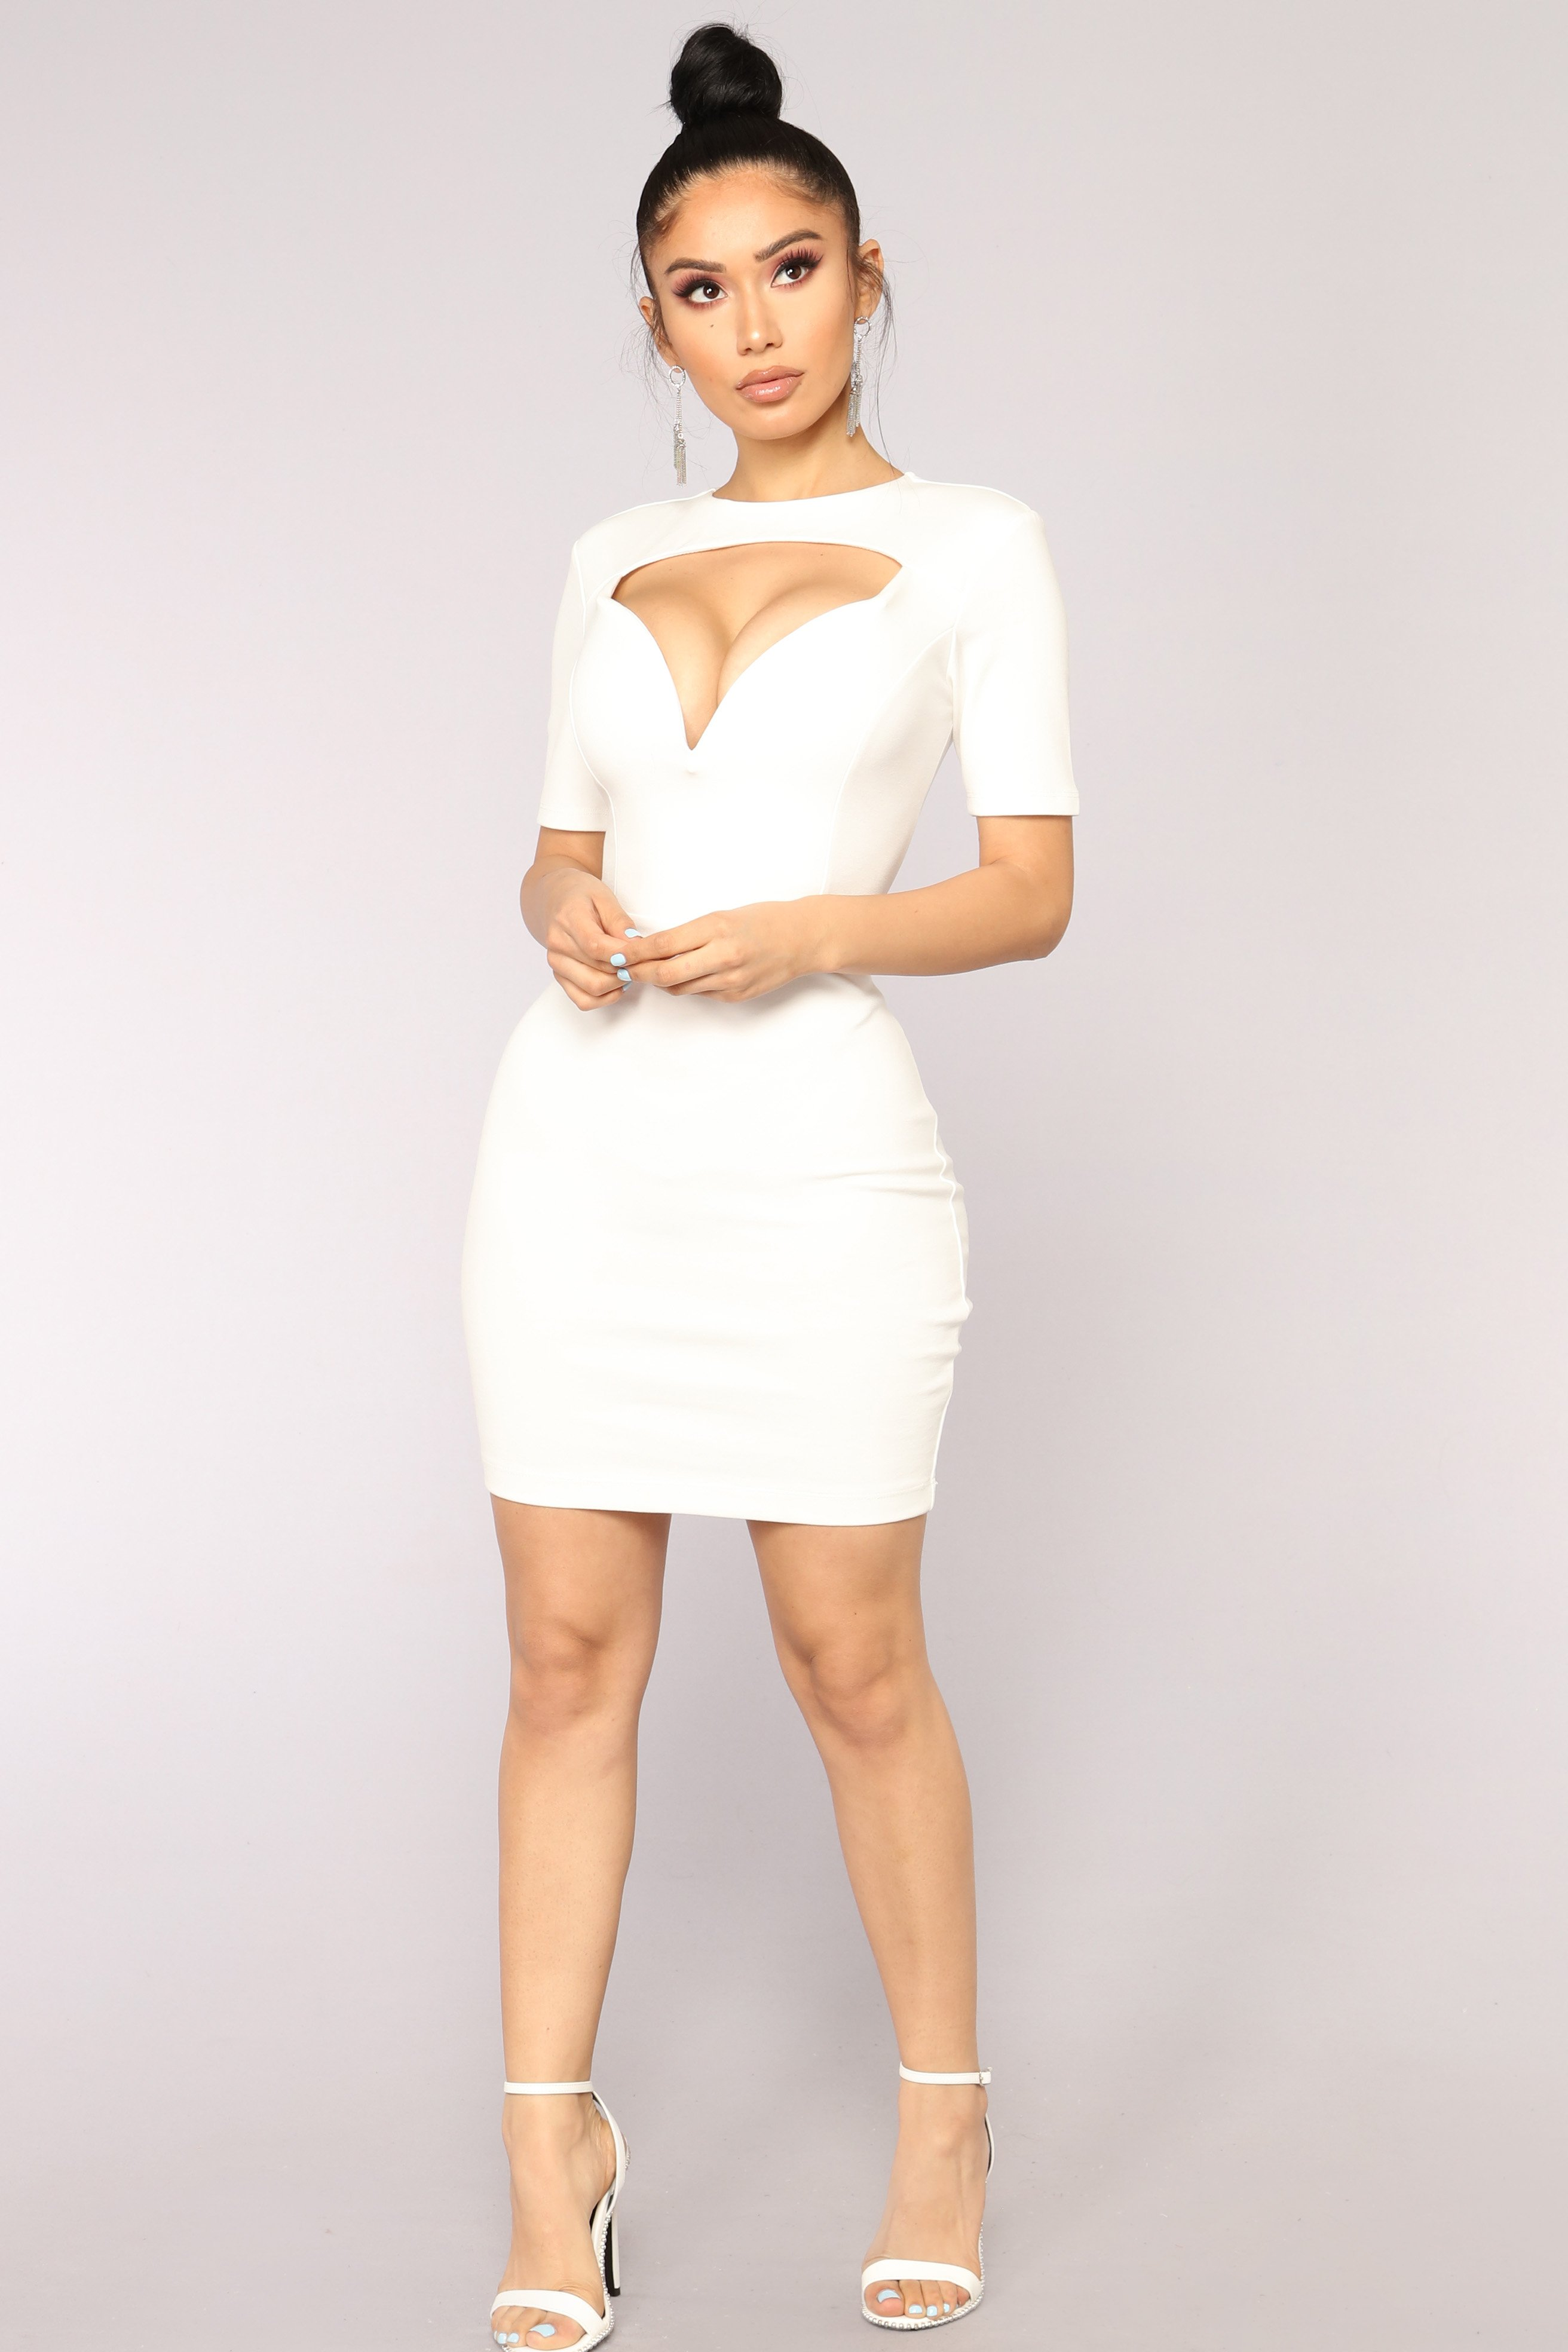

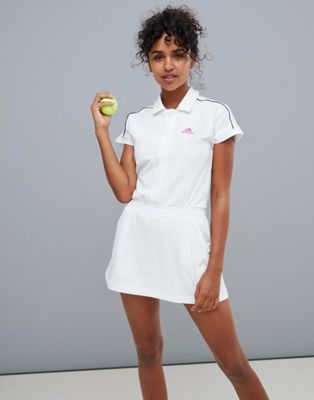

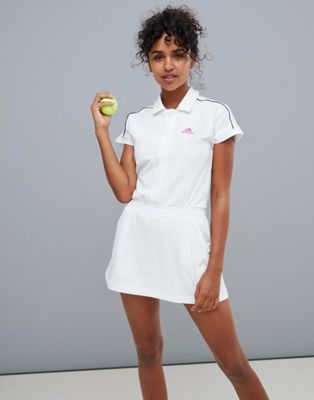

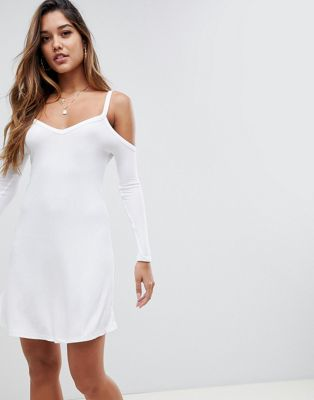

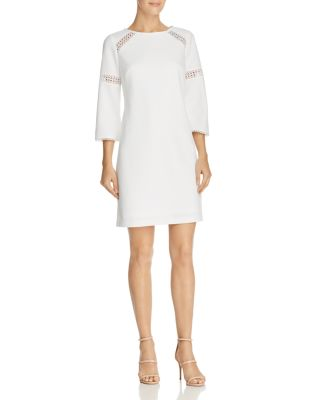

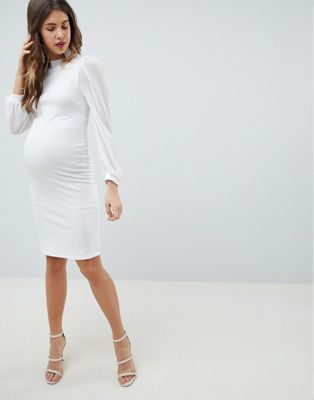

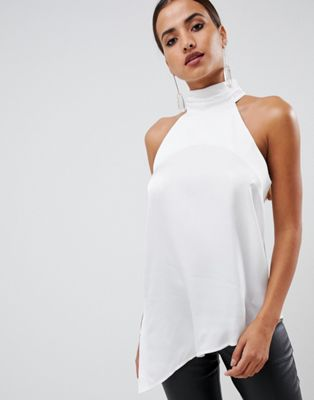

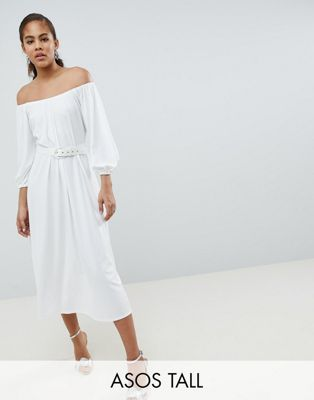

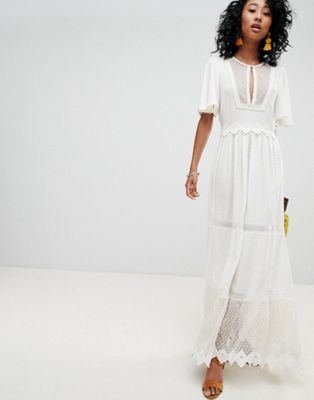

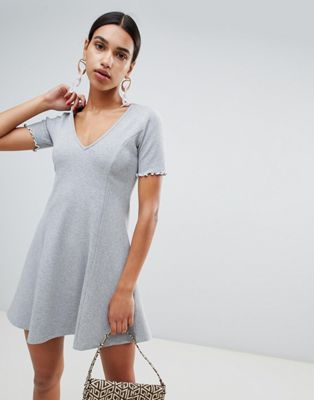

In [276]:
item = 10609
img_similar = img_score['product_images/'+str(item)+'.jpg'].sort_values(ascending =False)[:10].reset_index()

print(img_similar)

# show img
for i in range(len(img_similar)):
    display(Image(filename = './'+img_similar['index'][i], width=200, height=200))



## Method 4: Kmean clustering

In [183]:
df1 = df.drop(df.iloc[:,3:10], axis=1)
df1 = df1.drop('brand', axis=1)

# possible tags:
# category1 = ['polyester', 'cotton', 'spex', 'sleeves', 'jersey', 'woven', 'lining', 'lightweight', 'strech', 'vneck',\
#'crew', 'button', 'softtouch', 'tshirt', 'classic', 'straps', 'floral', 'lace', 'sleeveless', 'zip', 'collar',\
# 'loose', 'maxi', 'midi', 'mini', 'skirt', 'blouse', 'zipper', 'tank', 'baggy', 'neckline', 'ruffle']

category1 = ['crop', 'vneck', 'lace']

for word in category1:
    df1.loc[df.alltext.str.contains(word), word] = word
    df1[word] = df1[word].fillna('')

col_list = ['df1.' + word for word in category1]

df1['tag'] = df1.category + df1.crop + df1.vneck + df1.lace

groups = df1.groupby('tag')['alltext'].count().reset_index()  # 15 tags (df1.groupby('tag')['alltext'].count())
groups[groups.alltext == 1].shape # 0 tags have only 1 items
df1.groupby('tag')['alltext'].count()

tag
Dress               2818
Dresscrop             36
Dresscroplace          2
Dresscropvneck         6
Dresslace            498
Dressvneck           908
Dressvnecklace       122
Top                 3826
Topcrop              656
Topcroplace           38
Topcropvneck          51
Topcropvnecklace      10
Toplace              244
Topvneck             717
Topvnecklace          83
Name: alltext, dtype: int64

In [185]:

# MyDocs reading from a data frame
class MyDocs_tag(object):
    def __iter__(self):
        for i in range(df.shape[0]):
            yield TaggedDocument(words=simple_preprocess(df.iloc[i,0]), tags=['%s' % df1.iloc[i,-1]])  
            # TaggedDocument classify reviews

if not os.path.exists('models/doc2vec.model'):
    print("start traing doc2vec model...")
    documents_tag = MyDocs_tag()                                                          
    doc2vec_model = Doc2Vec(dm=0, dbow_words=1, vector_size=200, window=3, min_count=2, workers=cores)
    doc2vec_model.build_vocab(documents_tag)
    doc2vec_model.train(documents_tag, total_examples=doc2vec_model.corpus_count, epochs=100) 
    if not os.path.exists('models'):
        os.makedirs('models')
        doc2vec_model.save('models/doc2vec.model')
    else:
        doc2vec_model.save('models/doc2vec.model')
else:
    doc2vec_model = Doc2Vec.load('models/doc2vec.model')

start traing doc2vec model...


In [186]:
doc2vec_model.docvecs.most_similar('Top', topn=500)


[('Topcrop', 0.524876594543457),
 ('Topvneck', 0.40548089146614075),
 ('Dress', 0.2520239055156708),
 ('Toplace', 0.25147026777267456),
 ('Topcropvneck', 0.2357517033815384),
 ('Topcroplace', 0.15727587044239044),
 ('Topvnecklace', 0.13441067934036255),
 ('Dresscrop', 0.09117761999368668),
 ('Topcropvnecklace', 0.028299126774072647),
 ('Dresscropvneck', 0.019761215895414352),
 ('Dressvneck', -0.0009805653244256973),
 ('Dresscroplace', -0.010414279997348785),
 ('Dresslace', -0.059920016676187515),
 ('Dressvnecklace', -0.14629755914211273)]

In [273]:
sentences = MySentences()
# list(sentences)

In [330]:
model.infer_vector('cotton')

array([ 2.42893375e-03,  1.92786078e-03,  1.31044281e-03, -2.02535512e-03,
       -1.65567198e-03, -1.68046041e-03, -1.06956123e-03, -1.76922383e-03,
       -4.28745145e-04, -3.17090657e-04,  8.39758606e-04,  9.08226008e-04,
        1.12301984e-03,  4.32046072e-04,  2.48244172e-03,  1.05833204e-03,
        1.71973638e-03, -6.27622823e-04,  4.03822400e-04, -1.11824379e-03,
        2.38772552e-03,  1.03421335e-04, -5.01941890e-04, -9.45520645e-04,
       -1.21876784e-03,  5.86931594e-04, -1.07476057e-03,  1.21126650e-03,
        1.97226508e-03, -1.51570269e-03, -7.95088185e-04, -5.98329818e-04,
        2.77963962e-04, -1.73259515e-03, -2.11542309e-03,  1.21007056e-03,
        1.95966125e-03,  2.12557218e-03, -2.19947589e-03, -2.06061569e-03,
        2.42662826e-03, -3.23274231e-04,  2.36180006e-03, -2.24206859e-04,
        6.32061914e-04,  4.21342702e-04,  1.47907424e-03, -7.79645634e-04,
       -1.99487782e-03, -6.09386305e-04, -7.36199843e-04,  1.61282730e-03,
        2.20670435e-03, -

### use 10 clusters

In [275]:
import nltk
from nltk.cluster.kmeans import KMeansClusterer
NUM_CLUSTERS = 10
vectors = []

model = Doc2Vec.load('models/doc2vec_dm0_word0_vec200_win3_min2_epoch100.model')
for word in list(sentences):
    vectors.append(model.infer_vector(word))
    
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(vectors, assign_clusters=True)


In [279]:
assigned_clusters
df1['cluster'] = assigned_clusters

In [327]:
cluster_img = df1[df1.cluster==4].id.reset_index()

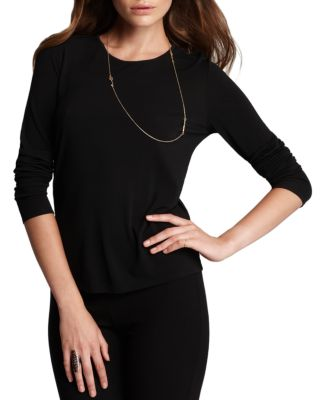

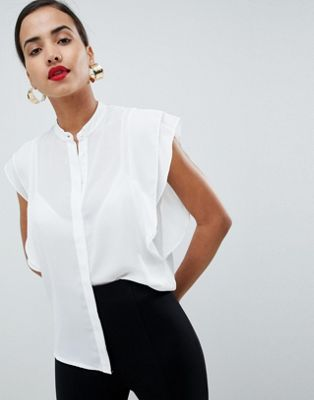

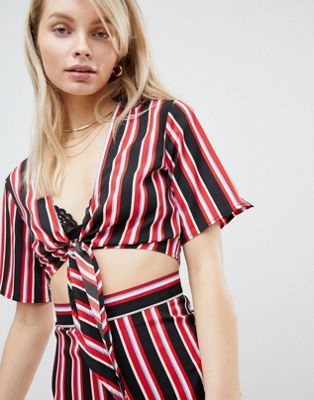

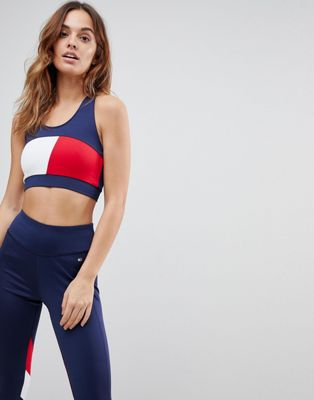

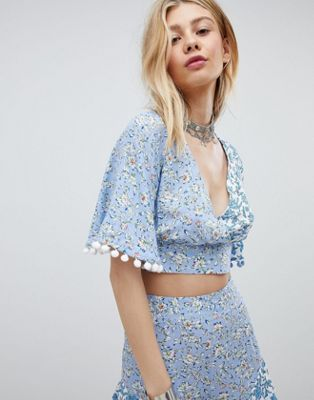

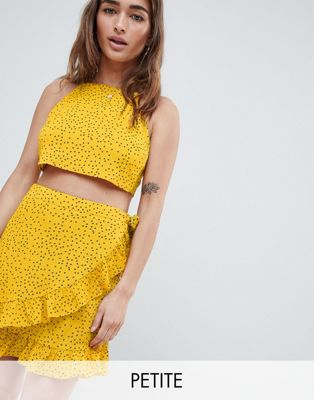

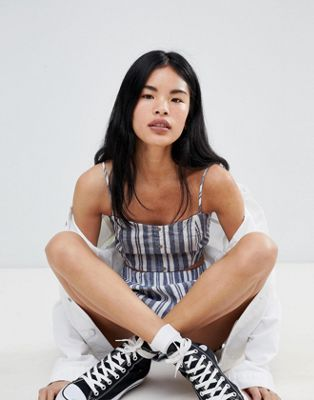

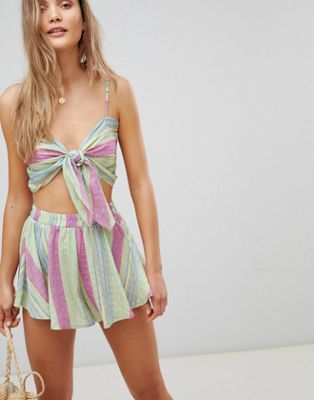

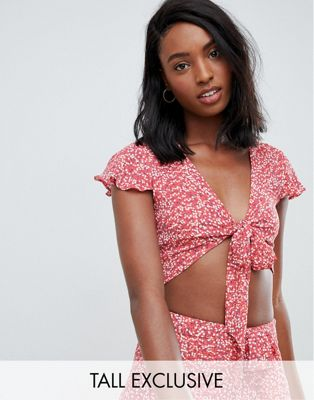

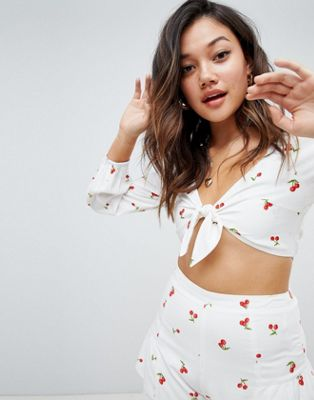

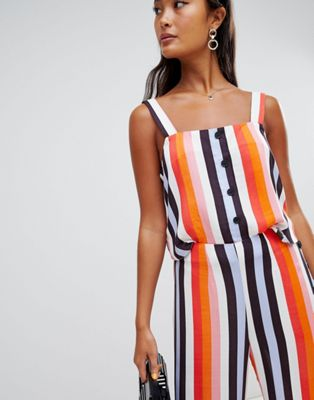

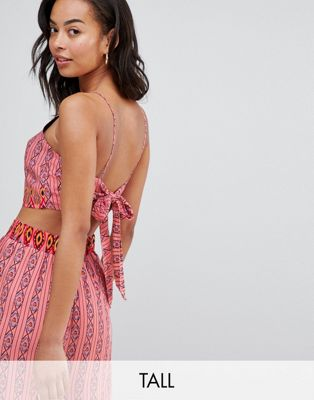

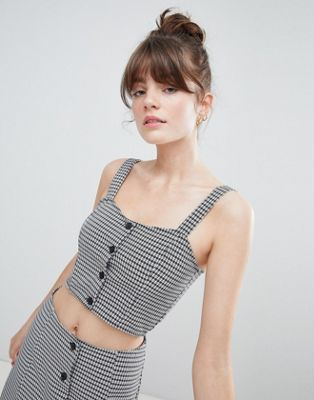

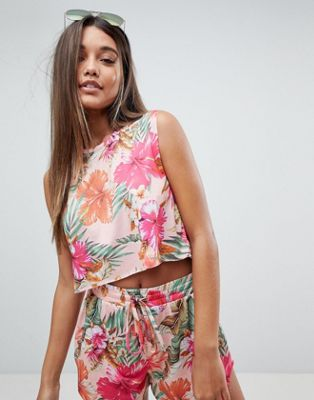

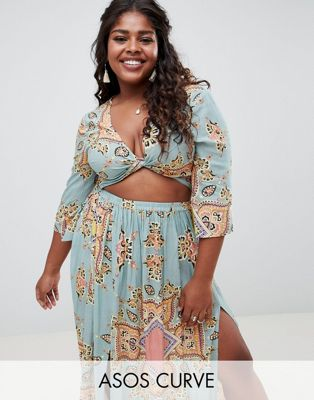

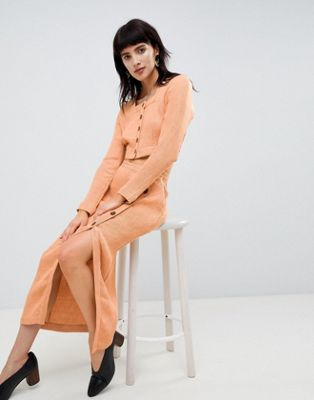

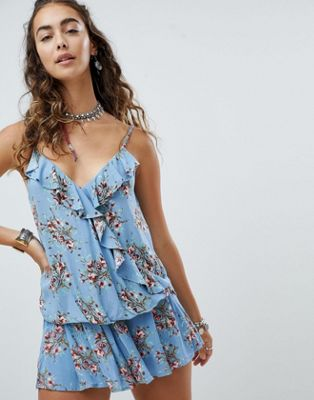

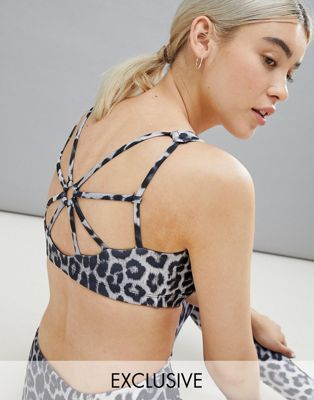

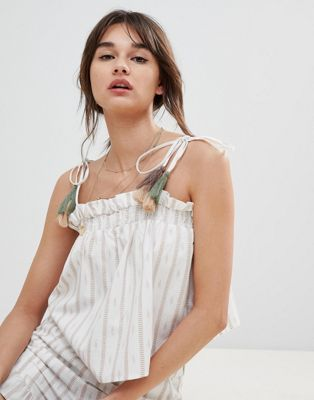

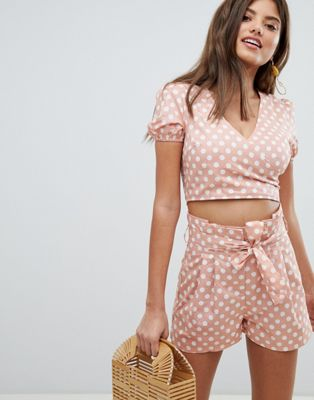

In [328]:
# show img
for i in range(20):
    display(Image(filename = './product_images/'+str(cluster_img.iloc[i,1])+'.jpg', width=200, height=200))

## Method 5: Topic modeling (LDA bag of words)

In [303]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer

lemtzer = WordNetLemmatizer()

def lemmatize_stemming(text):
    return lemtzer.lemmatize(text, pos='v')

# Write a function to perform the pre processing steps on the entire dataset
def preprocess(text):
    result=[]
    for token in simple_preprocess(text) :
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

In [304]:
doc_sample = df.alltext[0]

print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['cotton', 'tshirt', 'tshirt', 'in', 'lightweight', 'cotton', 'jersey', 'with', 'a', 'rounded', 'hem', '', 'slightly', 'longer', 'at', 'back', '', 'front', '', 'length', '', '', '', '', '', '', 'm', '']


Tokenized and lemmatized document: 
['cotton', 'tshirt', 'tshirt', 'lightweight', 'cotton', 'jersey', 'round', 'slightly', 'longer', 'length']


In [305]:
processed_docs  = []

for doc in df.alltext:
    processed_docs.append(preprocess(doc))

processed_docs

[['cotton',
  'tshirt',
  'tshirt',
  'lightweight',
  'cotton',
  'jersey',
  'round',
  'slightly',
  'longer',
  'length'],
 ['vneck',
  'jersey',
  'longsleeved',
  'airy',
  'vcose',
  'jersey',
  'vneck',
  'vcose'],
 ['jersey',
  'lace',
  'sleeveless',
  'soft',
  'vcose',
  'jersey',
  'lace',
  'section',
  'shoulder',
  'wide',
  'gather',
  'neckline',
  'vcose'],
 ['vneck',
  'conscious',
  'vneck',
  'airy',
  'jersey',
  'recycle',
  'polyester',
  'button',
  'length',
  'sleeves',
  'round',
  'slit',
  'side',
  'slightly',
  'longer',
  'polyester'],
 ['jersey', 'camole', 'camole', 'jersey', 'narrow', 'shoulder', 'strap'],
 ['short',
  'tshirt',
  'short',
  'tshirt',
  'soft',
  'jersey',
  'contrast',
  'trim',
  'neckline',
  'sleeves',
  'cotton',
  'polyester'],
 ['long',
  'tshirt',
  'long',
  'tshirt',
  'jersey',
  'sew',
  'cuff',
  'sleeves',
  'short',
  'sleeve'],
 ['tshirt', 'tshirt', 'soft', 'jersey'],
 ['tshirt', 'tshirt', 'soft', 'vcoseblend', 'jerse

In [306]:
import gensim
dictionary = gensim.corpora.Dictionary(processed_docs)

In [307]:
# dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n=100000)  # trim dictionary size to run faster later on

In [308]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2)],
 [(1, 2), (8, 1), (9, 1), (10, 2), (11, 2)],
 [(1, 2),
  (10, 2),
  (12, 1),
  (13, 2),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1)],
 [(1, 1),
  (2, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (8, 1),
  (11, 2),
  (20, 1),
  (21, 1),
  (22, 2),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1)],
 [(1, 2), (16, 1), (27, 2), (28, 1), (29, 1)],
 [(0, 1),
  (1, 1),
  (7, 2),
  (14, 1),
  (18, 1),
  (22, 1),
  (25, 1),
  (30, 1),
  (31, 2),
  (32, 1)],
 [(1, 1), (7, 2), (25, 1), (31, 1), (33, 1), (34, 2), (35, 1), (36, 1)],
 [(1, 1), (7, 2), (18, 1)],
 [(0, 1), (1, 1), (7, 2), (10, 1), (18, 1), (37, 1)],
 [(1, 1),
  (10, 1),
  (11, 2),
  (16, 1),
  (18, 1),
  (22, 1),
  (24, 1),
  (26, 1),
  (27, 2),
  (28, 1),
  (29, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1)],
 [(0, 1), (1, 2), (11, 2), (25, 1), (31, 2)],
 [(11, 2), (16, 1), (22, 1), (28, 1), (29, 2), (39, 1), (42, 1), (43, 1)],
 [(0, 1), (1, 1), (7, 2), (44, 2)

In [309]:
%%time
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2)
lda_model.save('lda.model')

CPU times: user 9.06 s, sys: 1.69 s, total: 10.7 s
Wall time: 12.1 s


In [310]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}\n'.format(idx, topic))

Topic: 0 Word: 0.040*"dress" + 0.033*"fabric" + 0.029*"wrap" + 0.027*"polyester" + 0.025*"spex" + 0.014*"neck" + 0.014*"weave" + 0.013*"main" + 0.013*"print" + 0.013*"black"

Topic: 1 Word: 0.035*"cotton" + 0.031*"neck" + 0.026*"main" + 0.025*"jersey" + 0.018*"spex" + 0.017*"sleeves" + 0.016*"polyester" + 0.015*"softtouch" + 0.014*"dress" + 0.014*"tshirt"

Topic: 2 Word: 0.039*"polyester" + 0.028*"neck" + 0.028*"dress" + 0.026*"line" + 0.021*"spex" + 0.013*"fabric" + 0.013*"body" + 0.010*"cotton" + 0.010*"fit" + 0.010*"sleeves"

Topic: 3 Word: 0.035*"polyester" + 0.034*"fabric" + 0.025*"weave" + 0.025*"neck" + 0.024*"dress" + 0.022*"main" + 0.021*"lightweight" + 0.020*"button" + 0.017*"body" + 0.016*"stretch"

Topic: 4 Word: 0.036*"polyester" + 0.029*"dress" + 0.025*"fabric" + 0.023*"body" + 0.021*"neck" + 0.018*"line" + 0.017*"floral" + 0.017*"main" + 0.016*"fit" + 0.015*"weave"



In [311]:
num = 5000
unseen_document = df.alltext[num]
print(unseen_document)

 floral tie front top floral  break out the blooms tiefront closure you re in control cropped length  fit   true to  exclusive to  lightweight woven fabric the kind that doesn t stretch main    polyester 


In [312]:
# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.9569449424743652	 Topic: 0.036*"polyester" + 0.029*"dress" + 0.025*"fabric" + 0.023*"body" + 0.021*"neck"
Score: 0.010815510526299477	 Topic: 0.035*"polyester" + 0.034*"fabric" + 0.025*"weave" + 0.025*"neck" + 0.024*"dress"
Score: 0.010788693092763424	 Topic: 0.039*"polyester" + 0.028*"neck" + 0.028*"dress" + 0.026*"line" + 0.021*"spex"
Score: 0.010730563662946224	 Topic: 0.040*"dress" + 0.033*"fabric" + 0.029*"wrap" + 0.027*"polyester" + 0.025*"spex"
Score: 0.010720320045948029	 Topic: 0.035*"cotton" + 0.031*"neck" + 0.026*"main" + 0.025*"jersey" + 0.018*"spex"


In [313]:
bow_vector

[(2, 1),
 (3, 1),
 (22, 1),
 (39, 1),
 (43, 1),
 (54, 1),
 (279, 1),
 (416, 1),
 (476, 2),
 (576, 1),
 (627, 1),
 (785, 1),
 (1275, 1),
 (1493, 1),
 (1532, 1),
 (1898, 1),
 (2680, 1)]

In [314]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      30.881538        1       1  0.093140  0.019484
2      25.560871        1       2  0.014684  0.059454
3      18.764076        1       3 -0.007405 -0.084397
4      16.513037        1       4 -0.005722 -0.031422
0       8.280476        1       5 -0.094696  0.036881, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
39    Default  4903.000000       fabric  4903.000000  30.0000  30.0000
226   Default  1399.000000         wrap  1399.000000  29.0000  29.0000
214   Default  6051.000000        dress  6051.000000  28.0000  28.0000
43    Default  2394.000000        weave  2394.000000  27.0000  27.0000
22    Default  7414.000000    polyester  7414.000000  26.0000  26.0000
3     Default  2076.000000  lightweight  2076.000000  25.0000  25.0000
379   Default  3958.000000         spex  3958.000000  24.0000  24.0000
20    Default  1925.000000       button  1925.000000  23.0000  23.0000
1362  Default  1259.000000        black  1259.000000  22.0000  22.0000
476   Default  1582.000000       floral  1582.000000  21.0000  21.0000
2680  Default  1565.000000         kind  1565.000000  20.0000  20.0000
41    Default  3670.000000         line  3670.000000  19.0000  19.0000
955   Default   627.000000    available   627.000000  18.0000  18.0000
392   Default  2328.000000        print  2328.000000  17.0000  17.0000
29    Default  1210.000000        strap  1210.000000  16.0000  16.0000
168   Default   919.000000      placket   919.000000  15.0000  15.0000
1     Default  2709.000000       jersey  2709.000000  14.0000  14.0000
129   Default   477.000000    crossover   477.000000  13.0000  13.0000
11    Default  1833.000000        vneck  1833.000000  12.0000  12.0000
447   Default  3366.000000         body  3366.000000  11.0000  11.0000
54    Default  2569.000000      stretch  2569.000000  10.0000  10.0000
10    Default  2089.000000        vcose  2089.000000   9.0000   9.0000
1532  Default  4541.000000         main  4541.000000   8.0000   8.0000
31    Default  1424.000000        short  1424.000000   7.0000   7.0000
112   Default   303.000000        linen   303.000000   6.0000   6.0000
197   Default   910.000000        drape   910.000000   5.0000   5.0000
198   Default   721.000000       softly   721.000000   4.0000   4.0000
404   Default   739.000000        rayon   739.000000   3.0000   3.0000
0     Default  4656.000000       cotton  4656.000000   2.0000   2.0000
791   Default   945.000000         mini   945.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
183    Topic5    92.736023      unlined   290.037170   1.3510  -5.4097
39     Topic5   689.059814       fabric  4903.651367   0.5289  -3.4041
404    Topic5   170.813477        rayon   739.579285   1.0258  -4.7988
379    Topic5   517.652954         spex  3958.562988   0.4569  -3.6901
150    Topic5    57.700874  elasticized   155.103302   1.5025  -5.8841
29     Topic5   212.134583        strap  1210.686279   0.7495  -4.5822
31     Topic5   231.574646        short  1424.384766   0.6747  -4.4945
63     Topic5   100.923355         seam   412.696106   1.0829  -5.3250
392    Topic5   279.274567        print  2328.567627   0.3705  -4.3072
22     Topic5   550.838928    polyester  7414.216797  -0.1084  -3.6280
43     Topic5   280.948059        weave  2394.201660   0.3486  -4.3012
10     Topic5   253.772980        vcose  2089.079834   0.3832  -4.4030
791    Topic5   153.011963         mini   945.934570   0.6696  -4.9089
11     Topic5   219.428619        vneck  1833.899536   0.3681  -4.5484
1112   Topic5   120.028854       smooth   618.381836   0.8519  -5.1517
3      Topic5   217.200714  lightweight  2076.828613   0.2335  -4.5586
25     Topic5   254.376038      sleeves  3272.704102  -0.0633  -4.4006
28     Topic5    96.708969   